# 以下テンプレート

In [93]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [94]:
import numpy as np
import datetime
import os
import copy

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"
Label = ['LeftHand','RightHand','LeftLeg','Rightleg','West','Chest']

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"
StorePath = "/media/takeyama/Transfer/02_ActivityResearch/"

if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+TITLE+DATE+'graph/')
GraphPath=StorePath+TITLE+DATE+'graph/'

**センサデータの読み込み**

In [95]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する．

In [96]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [97]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [98]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad, Adam, Adamax, RMSprop, Nadam
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


**Phase1 計測データの取得**

ここで行うことは，学習に用いるnpzファイルを読み込む

In [99]:
print DictionaryDataPath

/media/takeyama/Transfer/02_ActivityResearch/Participants01_First_1/dictionary/


In [100]:
DictName=os.listdir(DictionaryDataPath)
print DictName

['Chest.npz', 'LeftHand.npz', 'LeftLeg.npz', 'RightHand.npz', 'Rightleg.npz', 'West.npz']


In [101]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

**Phase2 window flame 作成 & Learning**

In [102]:
def AutoEncoder(TrainWindow,TestWindow,dim,opt,cname,batchSize):
    """
    TrainWindow: 訓練データ
    TestWindow: テストデータ
    dim: 中間層の次元数
    opt: 最適化関数
    cname: 各種データを保存する用の共通の名前
    """
    input_img = Input(shape=( TrainWindow.shape[1] ,))
    encoded = Dense(dim, activation='tanh')(input_img)
    decoded = Dense( TrainWindow.shape[1] , activation='linear')(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=opt, loss='mse')

    #plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')
    
    #early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    hist = autoencoder.fit(TrainWindow, TrainWindow,
                    nb_epoch=50,
                    verbose=2,
                    batch_size=batchSize,
                    shuffle=False,
                    validation_data=(TestWindow, TestWindow)
                    #callbacks=[early_stopping]
                          )
    time.sleep(0.1)

    encoded_imgs = encoder.predict(TrainWindow,batch_size=batchSize,verbose=1)
    decoded_imgs = decoder.predict(encoded_imgs,batch_size=batchSize,verbose=1)

    np.savez(StudyOutputPath+cname+'_Encoded',data=encoded_imgs)
    np.savez(StudyOutputPath+cname+'_Decoded',data=decoded_imgs)

    # save model and wights
    json_string = encoder.to_json()
    open(StudyOutputPath+cname+'_Encoded'+'.json', 'w').write(json_string)
    encoder.save_weights(ParametorPath+cname+'Encode_weights.h5',overwrite=True)

    json_string = decoder.to_json()
    open(StudyOutputPath+cname+'_Decoded'+'.json', 'w').write(json_string)
    decoder.save_weights(ParametorPath+cname+'Decord_weights.h5',overwrite=True)

    json_string = autoencoder.to_json()
    open(StudyOutputPath+cname+'_Net'+'.json', 'w').write(json_string)
    autoencoder.save_weights(ParametorPath+cname+'Net_weights.h5',overwrite=True)

    # plot loss
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    nb_epoch = len(loss)
    plt.plot(range(nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(ResultPath+cname+'.png')
    plt.show()

In [103]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

In [104]:
GetWindowFrame('AccX',Sensor1['AccX'],256,256/8,WindowDataPath)

this data had finished making


array([[ 0.8825,  0.8755,  0.8711, ...,  0.9233,  0.925 ,  0.9206],
       [ 0.8674,  0.8728,  0.8821, ...,  0.8264,  0.824 ,  0.8271],
       [ 0.8371,  0.8437,  0.8447, ...,  0.8532,  0.8471,  0.8498],
       ..., 
       [-0.1003, -0.0998, -0.0912, ..., -0.0995, -0.0942, -0.0925],
       [-0.1   , -0.1025, -0.1022, ..., -0.0939, -0.0986, -0.0966],
       [-0.0939, -0.0978, -0.0981, ..., -0.0976, -0.1015, -0.0973]])

# スクリプトの目的
本スクリプトの目的および学習方法を明記する
本スクリプトの目的は，**学習パラメータを今までのと比較して大きくことから，学習にどのような影響を与えるのか確認する**

パラメータ
* window幅 256,512,1024,2048,4096
* slidign幅 window幅/8
* Batch_size 32
* Optimizer Adam

this data had finished making
hiden node = 16
_AEdim=016_Win=0256_Sld=0032_Adam
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
0s - loss: 0.0269 - val_loss: 0.0338
Epoch 2/50
0s - loss: 0.0096 - val_loss: 0.0151
Epoch 3/50
0s - loss: 0.0077 - val_loss: 0.0077
Epoch 4/50
0s - loss: 0.0066 - val_loss: 0.0065
Epoch 5/50
0s - loss: 0.0058 - val_loss: 0.0064
Epoch 6/50
1s - loss: 0.0053 - val_loss: 0.0062
Epoch 7/50
1s - loss: 0.0048 - val_loss: 0.0072
Epoch 8/50
1s - loss: 0.0046 - val_loss: 0.0115
Epoch 9/50
1s - loss: 0.0045 - val_loss: 0.0101
Epoch 10/50
1s - loss: 0.0042 - val_loss: 0.0136
Epoch 11/50
1s - loss: 0.0041 - val_loss: 0.0138
Epoch 12/50
1s - loss: 0.0040 - val_loss: 0.0136
Epoch 13/50
1s - loss: 0.0040 - val_loss: 0.0131
Epoch 14/50
1s - loss: 0.0039 - val_loss: 0.0116
Epoch 15/50
1s - loss: 0.0038 - val_loss: 0.0095
Epoch 16/50
1s - loss: 0.0038 - val_loss: 0.0076
Epoch 17/50
1s - loss: 0.0039 - val_loss: 0.0049
Epoch 18/50
1s - loss: 0.0040 - val_loss: 0.00

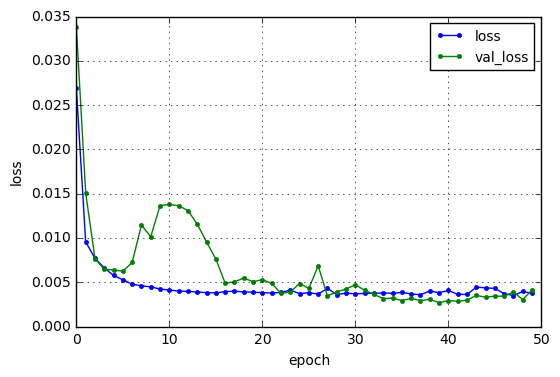

this data had finished making
hiden node = 16
_AEdim=016_Win=0512_Sld=0064_Adam
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0395 - val_loss: 0.0523
Epoch 2/50
0s - loss: 0.0152 - val_loss: 0.0348
Epoch 3/50
0s - loss: 0.0124 - val_loss: 0.0350
Epoch 4/50
0s - loss: 0.0116 - val_loss: 0.0351
Epoch 5/50
0s - loss: 0.0110 - val_loss: 0.0335
Epoch 6/50
0s - loss: 0.0105 - val_loss: 0.0313
Epoch 7/50
0s - loss: 0.0101 - val_loss: 0.0275
Epoch 8/50
0s - loss: 0.0104 - val_loss: 0.0259
Epoch 9/50
0s - loss: 0.0091 - val_loss: 0.0248
Epoch 10/50
0s - loss: 0.0092 - val_loss: 0.0218
Epoch 11/50
0s - loss: 0.0087 - val_loss: 0.0207
Epoch 12/50
0s - loss: 0.0090 - val_loss: 0.0255
Epoch 13/50
0s - loss: 0.0088 - val_loss: 0.0203
Epoch 14/50
0s - loss: 0.0081 - val_loss: 0.0184
Epoch 15/50
0s - loss: 0.0085 - val_loss: 0.0241
Epoch 16/50
0s - loss: 0.0098 - val_loss: 0.0244
Epoch 17/50
0s - loss: 0.0103 - val_loss: 0.0380
Epoch 18/50
0s - loss: 0.0113 - val_loss: 0.01

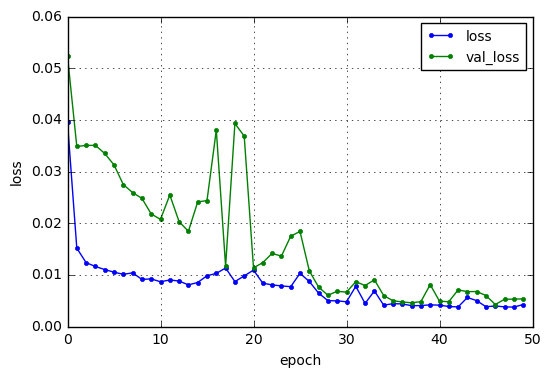

this data had finished making
hiden node = 16
_AEdim=016_Win=1024_Sld=0128_Adam
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0634 - val_loss: 0.0412
Epoch 2/50
0s - loss: 0.0371 - val_loss: 0.0328
Epoch 3/50
0s - loss: 0.0406 - val_loss: 0.0388
Epoch 4/50
0s - loss: 0.0408 - val_loss: 0.0221
Epoch 5/50
0s - loss: 0.0270 - val_loss: 0.0247
Epoch 6/50
0s - loss: 0.0294 - val_loss: 0.0213
Epoch 7/50
0s - loss: 0.0326 - val_loss: 0.0173
Epoch 8/50
0s - loss: 0.0352 - val_loss: 0.0309
Epoch 9/50
0s - loss: 0.0372 - val_loss: 0.0270
Epoch 10/50
0s - loss: 0.0351 - val_loss: 0.0204
Epoch 11/50
0s - loss: 0.0397 - val_loss: 0.0299
Epoch 12/50
0s - loss: 0.0299 - val_loss: 0.0142
Epoch 13/50
0s - loss: 0.0170 - val_loss: 0.0143
Epoch 14/50
0s - loss: 0.0278 - val_loss: 0.0250
Epoch 15/50
0s - loss: 0.0455 - val_loss: 0.0566
Epoch 16/50
0s - loss: 0.0328 - val_loss: 0.0155
Epoch 17/50
0s - loss: 0.0238 - val_loss: 0.0156
Epoch 18/50
0s - loss: 0.0178 - val_loss: 0.0144

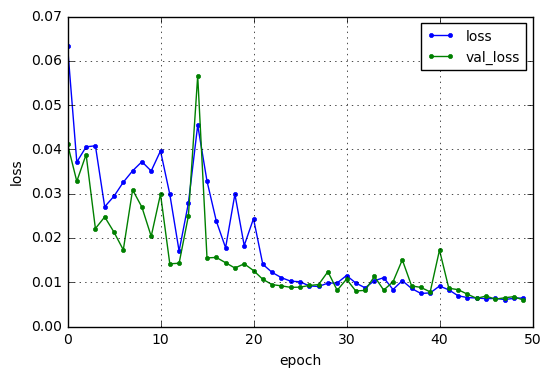

this data had finished making
hiden node = 16
_AEdim=016_Win=2048_Sld=0256_Adam
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0865 - val_loss: 0.0594
Epoch 2/50
0s - loss: 0.0563 - val_loss: 0.0566
Epoch 3/50
0s - loss: 0.0584 - val_loss: 0.0536
Epoch 4/50
0s - loss: 0.0584 - val_loss: 0.0614
Epoch 5/50
0s - loss: 0.0478 - val_loss: 0.0524
Epoch 6/50
0s - loss: 0.0567 - val_loss: 0.0621
Epoch 7/50
0s - loss: 0.0668 - val_loss: 0.0665
Epoch 8/50
0s - loss: 0.0552 - val_loss: 0.0614
Epoch 9/50
0s - loss: 0.0484 - val_loss: 0.0352
Epoch 10/50
0s - loss: 0.0450 - val_loss: 0.0345
Epoch 11/50
0s - loss: 0.0692 - val_loss: 0.0569
Epoch 12/50
0s - loss: 0.0580 - val_loss: 0.0691
Epoch 13/50
0s - loss: 0.0583 - val_loss: 0.0738
Epoch 14/50
0s - loss: 0.0546 - val_loss: 0.0549
Epoch 15/50
0s - loss: 0.0533 - val_loss: 0.0688
Epoch 16/50
0s - loss: 0.0533 - val_loss: 0.0724
Epoch 17/50
0s - loss: 0.0524 - val_loss: 0.0640
Epoch 18/50
0s - loss: 0.0511 - val_loss: 0.0688

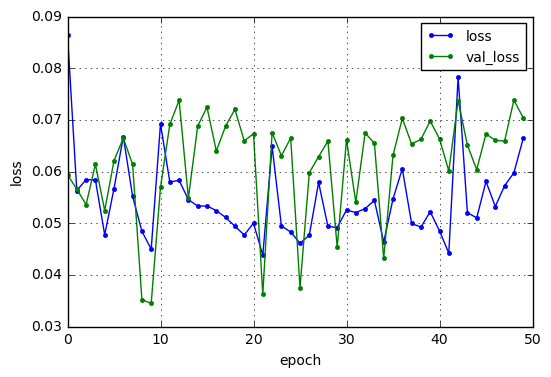

this data had finished making
hiden node = 16
_AEdim=016_Win=4096_Sld=0512_Adam
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1275 - val_loss: 0.0616
Epoch 2/50
0s - loss: 0.0715 - val_loss: 0.0633
Epoch 3/50
0s - loss: 0.0609 - val_loss: 0.0626
Epoch 4/50
0s - loss: 0.0643 - val_loss: 0.0585
Epoch 5/50
0s - loss: 0.0607 - val_loss: 0.0764
Epoch 6/50
0s - loss: 0.0591 - val_loss: 0.0630
Epoch 7/50
0s - loss: 0.0599 - val_loss: 0.0622
Epoch 8/50
0s - loss: 0.0615 - val_loss: 0.0672
Epoch 9/50
0s - loss: 0.0607 - val_loss: 0.0650
Epoch 10/50
0s - loss: 0.0720 - val_loss: 0.0795
Epoch 11/50
0s - loss: 0.0641 - val_loss: 0.0707
Epoch 12/50
0s - loss: 0.0651 - val_loss: 0.0691
Epoch 13/50
0s - loss: 0.0618 - val_loss: 0.0675
Epoch 14/50
0s - loss: 0.0612 - val_loss: 0.0687
Epoch 15/50
0s - loss: 0.0626 - val_loss: 0.0608
Epoch 16/50
0s - loss: 0.0603 - val_loss: 0.0795
Epoch 17/50
0s - loss: 0.0595 - val_loss: 0.0639
Epoch 18/50
0s - loss: 0.0632 - val_loss: 0.0692

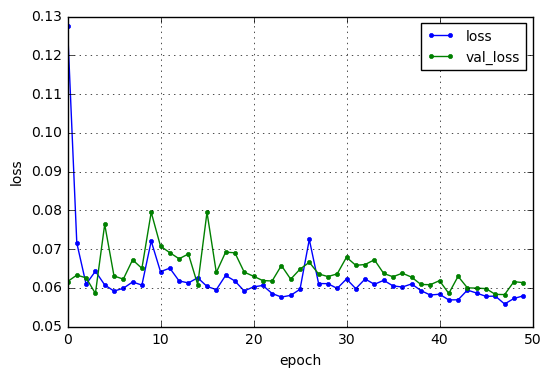

In [105]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='Adam'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
        
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

学習の過程を見ると，明らかにおかしな学習をしていることがわかる．これの原因としてを列挙する
* 学習の際に入力データをシャッフルせず，時系列順に渡しているから
* 最適化方法が合ってない
* バッチサイズが最適値でない  
他にも原因あるが，とりあえず一番の内容はもう少し考える．
まずは，最適化方法を試す．

this data had finished making
hiden node = 16
_AEdim=016_Win=0256_Sld=0032_rmsprop
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0184 - val_loss: 0.0087
Epoch 2/50
0s - loss: 0.0058 - val_loss: 0.0082
Epoch 3/50
1s - loss: 0.0052 - val_loss: 0.0083
Epoch 4/50
1s - loss: 0.0048 - val_loss: 0.0084
Epoch 5/50
1s - loss: 0.0047 - val_loss: 0.0085
Epoch 6/50
1s - loss: 0.0045 - val_loss: 0.0085
Epoch 7/50
1s - loss: 0.0044 - val_loss: 0.0083
Epoch 8/50
1s - loss: 0.0043 - val_loss: 0.0082
Epoch 9/50
1s - loss: 0.0042 - val_loss: 0.0080
Epoch 10/50
1s - loss: 0.0042 - val_loss: 0.0081
Epoch 11/50
1s - loss: 0.0041 - val_loss: 0.0081
Epoch 12/50
1s - loss: 0.0041 - val_loss: 0.0080
Epoch 13/50
1s - loss: 0.0041 - val_loss: 0.0081
Epoch 14/50
1s - loss: 0.0040 - val_loss: 0.0080
Epoch 15/50
1s - loss: 0.0040 - val_loss: 0.0079
Epoch 16/50
1s - loss: 0.0040 - val_loss: 0.0077
Epoch 17/50
1s - loss: 0.0040 - val_loss: 0.0076
Epoch 18/50
1s - loss: 0.0040 - val_loss: 0

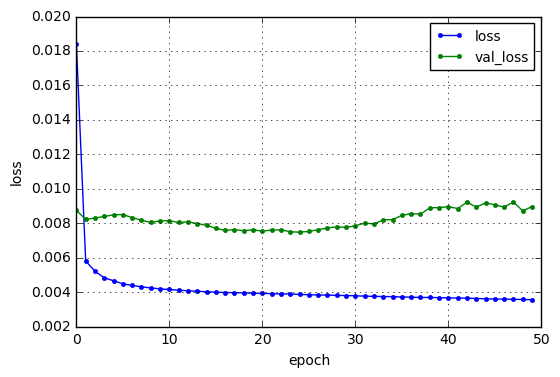

this data had finished making
hiden node = 16
_AEdim=016_Win=0512_Sld=0064_rmsprop
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.0295 - val_loss: 0.0119
Epoch 2/50
0s - loss: 0.0098 - val_loss: 0.0103
Epoch 3/50
0s - loss: 0.0094 - val_loss: 0.0132
Epoch 4/50
0s - loss: 0.0089 - val_loss: 0.0120
Epoch 5/50
0s - loss: 0.0086 - val_loss: 0.0114
Epoch 6/50
0s - loss: 0.0082 - val_loss: 0.0111
Epoch 7/50
0s - loss: 0.0080 - val_loss: 0.0108
Epoch 8/50
0s - loss: 0.0078 - val_loss: 0.0107
Epoch 9/50
0s - loss: 0.0076 - val_loss: 0.0102
Epoch 10/50
0s - loss: 0.0074 - val_loss: 0.0100
Epoch 11/50
0s - loss: 0.0073 - val_loss: 0.0098
Epoch 12/50
0s - loss: 0.0072 - val_loss: 0.0099
Epoch 13/50
0s - loss: 0.0071 - val_loss: 0.0099
Epoch 14/50
0s - loss: 0.0070 - val_loss: 0.0098
Epoch 15/50
0s - loss: 0.0069 - val_loss: 0.0099
Epoch 16/50
0s - loss: 0.0069 - val_loss: 0.0099
Epoch 17/50
0s - loss: 0.0068 - val_loss: 0.0099
Epoch 18/50
0s - loss: 0.0068 - val_loss: 0

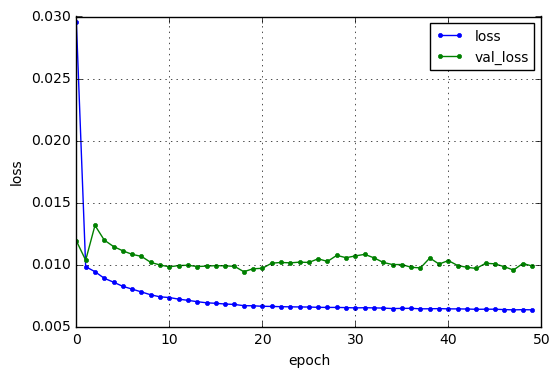

this data had finished making
hiden node = 16
_AEdim=016_Win=1024_Sld=0128_rmsprop
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0475 - val_loss: 0.0195
Epoch 2/50
0s - loss: 0.0171 - val_loss: 0.0162
Epoch 3/50
0s - loss: 0.0163 - val_loss: 0.0145
Epoch 4/50
0s - loss: 0.0163 - val_loss: 0.0143
Epoch 5/50
0s - loss: 0.0157 - val_loss: 0.0142
Epoch 6/50
0s - loss: 0.0152 - val_loss: 0.0144
Epoch 7/50
0s - loss: 0.0149 - val_loss: 0.0143
Epoch 8/50
0s - loss: 0.0148 - val_loss: 0.0136
Epoch 9/50
0s - loss: 0.0145 - val_loss: 0.0130
Epoch 10/50
0s - loss: 0.0143 - val_loss: 0.0126
Epoch 11/50
0s - loss: 0.0142 - val_loss: 0.0131
Epoch 12/50
0s - loss: 0.0139 - val_loss: 0.0130
Epoch 13/50
0s - loss: 0.0137 - val_loss: 0.0138
Epoch 14/50
0s - loss: 0.0135 - val_loss: 0.0158
Epoch 15/50
0s - loss: 0.0133 - val_loss: 0.0163
Epoch 16/50
0s - loss: 0.0128 - val_loss: 0.0153
Epoch 17/50
0s - loss: 0.0128 - val_loss: 0.0160
Epoch 18/50
0s - loss: 0.0128 - val_loss: 0.0

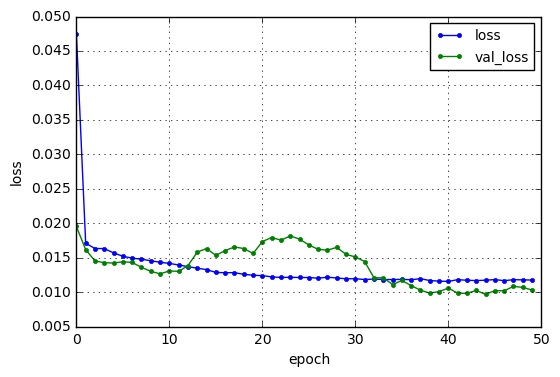

this data had finished making
hiden node = 16
_AEdim=016_Win=2048_Sld=0256_rmsprop
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0748 - val_loss: 0.0315
Epoch 2/50
0s - loss: 0.0322 - val_loss: 0.0223
Epoch 3/50
0s - loss: 0.0306 - val_loss: 0.0204
Epoch 4/50
0s - loss: 0.0270 - val_loss: 0.0277
Epoch 5/50
0s - loss: 0.0280 - val_loss: 0.0258
Epoch 6/50
0s - loss: 0.0250 - val_loss: 0.0352
Epoch 7/50
0s - loss: 0.0281 - val_loss: 0.0188
Epoch 8/50
0s - loss: 0.0277 - val_loss: 0.0298
Epoch 9/50
0s - loss: 0.0286 - val_loss: 0.0232
Epoch 10/50
0s - loss: 0.0269 - val_loss: 0.0225
Epoch 11/50
0s - loss: 0.0280 - val_loss: 0.0197
Epoch 12/50
0s - loss: 0.0281 - val_loss: 0.0280
Epoch 13/50
0s - loss: 0.0361 - val_loss: 0.0294
Epoch 14/50
0s - loss: 0.0303 - val_loss: 0.0256
Epoch 15/50
0s - loss: 0.0272 - val_loss: 0.0216
Epoch 16/50
0s - loss: 0.0269 - val_loss: 0.0223
Epoch 17/50
0s - loss: 0.0261 - val_loss: 0.0226
Epoch 18/50
0s - loss: 0.0286 - val_loss: 0.0

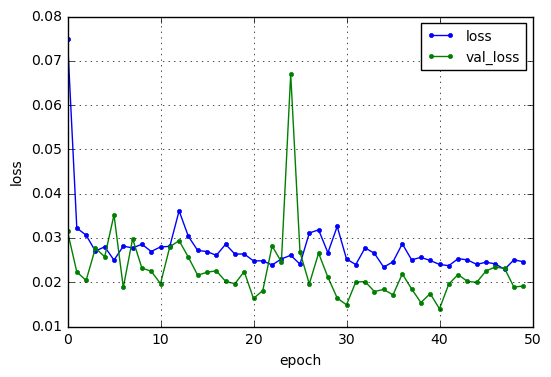

this data had finished making
hiden node = 16
_AEdim=016_Win=4096_Sld=0512_rmsprop
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.1132 - val_loss: 0.0717
Epoch 2/50
0s - loss: 0.0570 - val_loss: 0.0684
Epoch 3/50
0s - loss: 0.0478 - val_loss: 0.0414
Epoch 4/50
0s - loss: 0.0432 - val_loss: 0.0587
Epoch 5/50
0s - loss: 0.0515 - val_loss: 0.0490
Epoch 6/50
0s - loss: 0.0446 - val_loss: 0.0531
Epoch 7/50
0s - loss: 0.0427 - val_loss: 0.0500
Epoch 8/50
0s - loss: 0.0454 - val_loss: 0.0490
Epoch 9/50
0s - loss: 0.0463 - val_loss: 0.0687
Epoch 10/50
0s - loss: 0.0432 - val_loss: 0.0478
Epoch 11/50
0s - loss: 0.0396 - val_loss: 0.0574
Epoch 12/50
0s - loss: 0.0387 - val_loss: 0.0407
Epoch 13/50
0s - loss: 0.0451 - val_loss: 0.0478
Epoch 14/50
0s - loss: 0.0381 - val_loss: 0.0669
Epoch 15/50
0s - loss: 0.0410 - val_loss: 0.0402
Epoch 16/50
0s - loss: 0.0421 - val_loss: 0.0457
Epoch 17/50
0s - loss: 0.0412 - val_loss: 0.0453
Epoch 18/50
0s - loss: 0.0523 - val_loss: 0.0

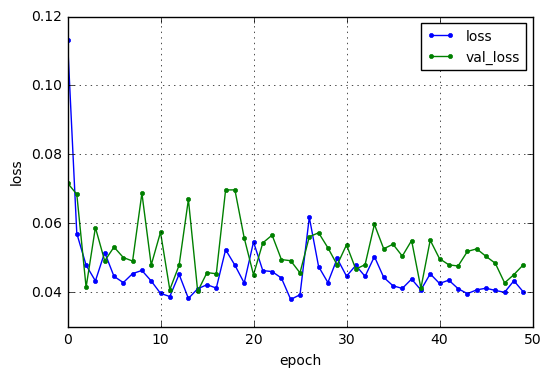

In [107]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='rmsprop'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

バッチサイズを変更してみる，まずは試しに先ほどの半分で学習する

this data had finished making
hiden node = 16
_AEdim=016_Win=0256_Sld=0032_rmsprop
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
3s - loss: 0.0130 - val_loss: 0.0084
Epoch 2/50
3s - loss: 0.0050 - val_loss: 0.0077
Epoch 3/50
3s - loss: 0.0045 - val_loss: 0.0078
Epoch 4/50
3s - loss: 0.0043 - val_loss: 0.0080
Epoch 5/50
3s - loss: 0.0042 - val_loss: 0.0083
Epoch 6/50
3s - loss: 0.0041 - val_loss: 0.0088
Epoch 7/50
3s - loss: 0.0040 - val_loss: 0.0095
Epoch 8/50
3s - loss: 0.0039 - val_loss: 0.0089
Epoch 9/50
3s - loss: 0.0039 - val_loss: 0.0087
Epoch 10/50
3s - loss: 0.0039 - val_loss: 0.0078
Epoch 11/50
3s - loss: 0.0038 - val_loss: 0.0081
Epoch 12/50
3s - loss: 0.0038 - val_loss: 0.0070
Epoch 13/50
3s - loss: 0.0038 - val_loss: 0.0068
Epoch 14/50
3s - loss: 0.0037 - val_loss: 0.0068
Epoch 15/50
3s - loss: 0.0037 - val_loss: 0.0067
Epoch 16/50
3s - loss: 0.0037 - val_loss: 0.0068
Epoch 17/50
3s - loss: 0.0037 - val_loss: 0.0069
Epoch 18/50
3s - loss: 0.0037 - val_loss: 0

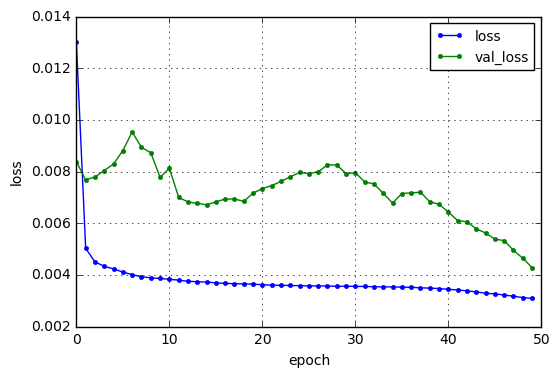

this data had finished making
hiden node = 16
_AEdim=016_Win=0512_Sld=0064_rmsprop
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0213 - val_loss: 0.0226
Epoch 2/50
1s - loss: 0.0085 - val_loss: 0.0263
Epoch 3/50
1s - loss: 0.0079 - val_loss: 0.0294
Epoch 4/50
1s - loss: 0.0075 - val_loss: 0.0324
Epoch 5/50
1s - loss: 0.0072 - val_loss: 0.0359
Epoch 6/50
1s - loss: 0.0071 - val_loss: 0.0356
Epoch 7/50
1s - loss: 0.0069 - val_loss: 0.0334
Epoch 8/50
1s - loss: 0.0067 - val_loss: 0.0333
Epoch 9/50
1s - loss: 0.0066 - val_loss: 0.0335
Epoch 10/50
1s - loss: 0.0066 - val_loss: 0.0333
Epoch 11/50
1s - loss: 0.0065 - val_loss: 0.0333
Epoch 12/50
1s - loss: 0.0064 - val_loss: 0.0316
Epoch 13/50
1s - loss: 0.0063 - val_loss: 0.0308
Epoch 14/50
1s - loss: 0.0063 - val_loss: 0.0296
Epoch 15/50
1s - loss: 0.0062 - val_loss: 0.0247
Epoch 16/50
1s - loss: 0.0062 - val_loss: 0.0242
Epoch 17/50
1s - loss: 0.0062 - val_loss: 0.0304
Epoch 18/50
1s - loss: 0.0061 - val_loss: 0

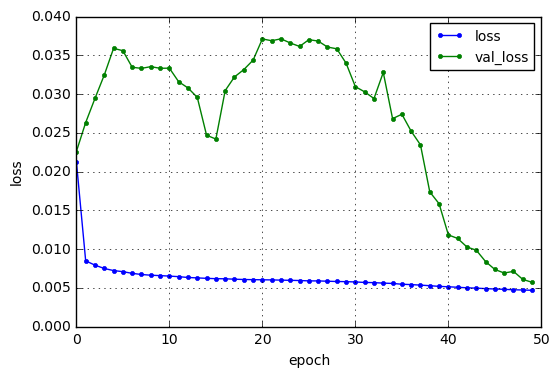

this data had finished making
hiden node = 16
_AEdim=016_Win=1024_Sld=0128_rmsprop
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.0358 - val_loss: 0.0145
Epoch 2/50
0s - loss: 0.0146 - val_loss: 0.0191
Epoch 3/50
0s - loss: 0.0140 - val_loss: 0.0212
Epoch 4/50
0s - loss: 0.0137 - val_loss: 0.0256
Epoch 5/50
0s - loss: 0.0132 - val_loss: 0.0257
Epoch 6/50
0s - loss: 0.0127 - val_loss: 0.0330
Epoch 7/50
0s - loss: 0.0126 - val_loss: 0.0313
Epoch 8/50
0s - loss: 0.0121 - val_loss: 0.0263
Epoch 9/50
0s - loss: 0.0120 - val_loss: 0.0217
Epoch 10/50
0s - loss: 0.0118 - val_loss: 0.0291
Epoch 11/50
0s - loss: 0.0116 - val_loss: 0.0316
Epoch 12/50
0s - loss: 0.0114 - val_loss: 0.0334
Epoch 13/50
0s - loss: 0.0115 - val_loss: 0.0316
Epoch 14/50
0s - loss: 0.0115 - val_loss: 0.0323
Epoch 15/50
0s - loss: 0.0114 - val_loss: 0.0339
Epoch 16/50
0s - loss: 0.0114 - val_loss: 0.0331
Epoch 17/50
0s - loss: 0.0115 - val_loss: 0.0199
Epoch 18/50
0s - loss: 0.0114 - val_loss: 0.0

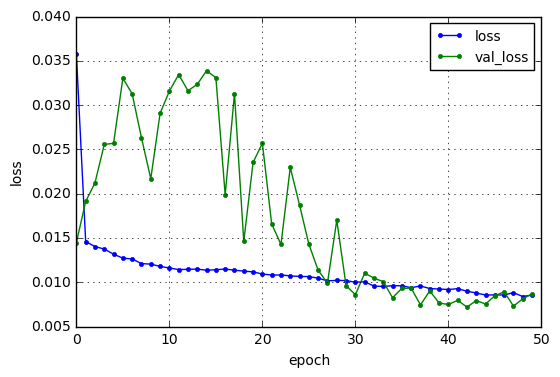

this data had finished making
hiden node = 16
_AEdim=016_Win=2048_Sld=0256_rmsprop
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.0580 - val_loss: 0.0483
Epoch 2/50
0s - loss: 0.0274 - val_loss: 0.0323
Epoch 3/50
0s - loss: 0.0257 - val_loss: 0.0296
Epoch 4/50
0s - loss: 0.0242 - val_loss: 0.0225
Epoch 5/50
0s - loss: 0.0233 - val_loss: 0.0250
Epoch 6/50
0s - loss: 0.0229 - val_loss: 0.0304
Epoch 7/50
0s - loss: 0.0230 - val_loss: 0.0254
Epoch 8/50
0s - loss: 0.0224 - val_loss: 0.0176
Epoch 9/50
0s - loss: 0.0236 - val_loss: 0.0201
Epoch 10/50
0s - loss: 0.0228 - val_loss: 0.0380
Epoch 11/50
0s - loss: 0.0240 - val_loss: 0.0224
Epoch 12/50
0s - loss: 0.0222 - val_loss: 0.0201
Epoch 13/50
0s - loss: 0.0229 - val_loss: 0.0217
Epoch 14/50
0s - loss: 0.0222 - val_loss: 0.0244
Epoch 15/50
0s - loss: 0.0234 - val_loss: 0.0276
Epoch 16/50
0s - loss: 0.0225 - val_loss: 0.0236
Epoch 17/50
0s - loss: 0.0215 - val_loss: 0.0261
Epoch 18/50
0s - loss: 0.0212 - val_loss: 0.0

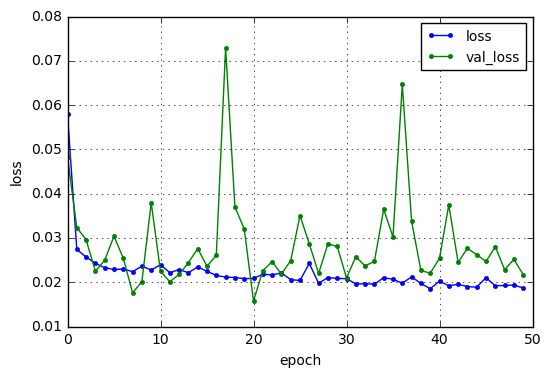

this data had finished making
hiden node = 16
_AEdim=016_Win=4096_Sld=0512_rmsprop
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.0868 - val_loss: 0.0609
Epoch 2/50
0s - loss: 0.0458 - val_loss: 0.0478
Epoch 3/50
0s - loss: 0.0415 - val_loss: 0.0484
Epoch 4/50
0s - loss: 0.0427 - val_loss: 0.0883
Epoch 5/50
0s - loss: 0.0460 - val_loss: 0.0696
Epoch 6/50
0s - loss: 0.0413 - val_loss: 0.0509
Epoch 7/50
0s - loss: 0.0469 - val_loss: 0.0575
Epoch 8/50
0s - loss: 0.0493 - val_loss: 0.0546
Epoch 9/50
0s - loss: 0.0520 - val_loss: 0.0568
Epoch 10/50
0s - loss: 0.0433 - val_loss: 0.0666
Epoch 11/50
0s - loss: 0.0464 - val_loss: 0.0478
Epoch 12/50
0s - loss: 0.0514 - val_loss: 0.0602
Epoch 13/50
0s - loss: 0.0436 - val_loss: 0.0561
Epoch 14/50
0s - loss: 0.0453 - val_loss: 0.0540
Epoch 15/50
0s - loss: 0.0425 - val_loss: 0.0508
Epoch 16/50
0s - loss: 0.0400 - val_loss: 0.0537
Epoch 17/50
0s - loss: 0.0446 - val_loss: 0.0592
Epoch 18/50
0s - loss: 0.0422 - val_loss: 0.0

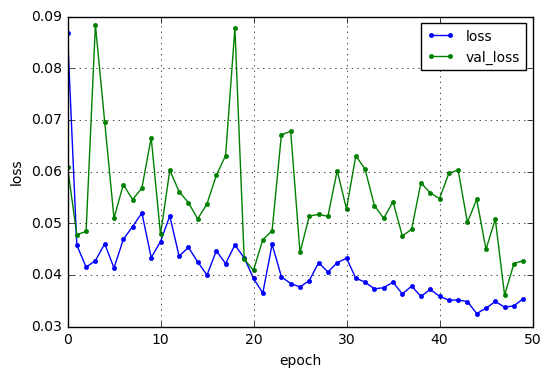

In [108]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 16
Optim='rmsprop'
AEDimention = 16

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
    
    print "hiden node = "+str(AEDimention)
    
    CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
    '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
    print CommonName

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)

    AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

電話を受けてやっていくこと  
まず，学習方法のパラメータを変更して見ていく．  
まず，中間層の値を変えてみるー＞入力データと同じ，２分の１，４分の１，８分の１でやる  
次に，最適化法保をＳＧＤ試す  

this data had finished making
hiden node = 256
_AEdim=256_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0454 - val_loss: 0.0130
Epoch 2/50
1s - loss: 0.0105 - val_loss: 0.0118
Epoch 3/50
1s - loss: 0.0097 - val_loss: 0.0108
Epoch 4/50
1s - loss: 0.0090 - val_loss: 0.0101
Epoch 5/50
1s - loss: 0.0085 - val_loss: 0.0095
Epoch 6/50
1s - loss: 0.0081 - val_loss: 0.0090
Epoch 7/50
1s - loss: 0.0077 - val_loss: 0.0086
Epoch 8/50
1s - loss: 0.0074 - val_loss: 0.0083
Epoch 9/50
1s - loss: 0.0071 - val_loss: 0.0080
Epoch 10/50
1s - loss: 0.0069 - val_loss: 0.0077
Epoch 11/50
1s - loss: 0.0067 - val_loss: 0.0074
Epoch 12/50
1s - loss: 0.0065 - val_loss: 0.0072
Epoch 13/50
1s - loss: 0.0063 - val_loss: 0.0070
Epoch 14/50
1s - loss: 0.0061 - val_loss: 0.0068
Epoch 15/50
1s - loss: 0.0060 - val_loss: 0.0067
Epoch 16/50
0s - loss: 0.0058 - val_loss: 0.0065
Epoch 17/50
1s - loss: 0.0057 - val_loss: 0.0064
Epoch 18/50
1s - loss: 0.0056 - val_loss: 0.00

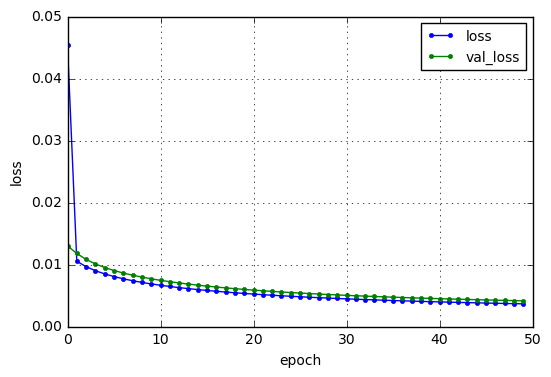

hiden node = 128
_AEdim=128_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.0749 - val_loss: 0.0151
Epoch 2/50
1s - loss: 0.0125 - val_loss: 0.0134
Epoch 3/50
1s - loss: 0.0111 - val_loss: 0.0121
Epoch 4/50
1s - loss: 0.0101 - val_loss: 0.0113
Epoch 5/50
1s - loss: 0.0095 - val_loss: 0.0106
Epoch 6/50
1s - loss: 0.0090 - val_loss: 0.0101
Epoch 7/50
1s - loss: 0.0085 - val_loss: 0.0097
Epoch 8/50
1s - loss: 0.0082 - val_loss: 0.0094
Epoch 9/50
1s - loss: 0.0079 - val_loss: 0.0091
Epoch 10/50
1s - loss: 0.0077 - val_loss: 0.0088
Epoch 11/50
1s - loss: 0.0074 - val_loss: 0.0086
Epoch 12/50
1s - loss: 0.0072 - val_loss: 0.0083
Epoch 13/50
1s - loss: 0.0071 - val_loss: 0.0081
Epoch 14/50
1s - loss: 0.0069 - val_loss: 0.0080
Epoch 15/50
1s - loss: 0.0067 - val_loss: 0.0078
Epoch 16/50
1s - loss: 0.0066 - val_loss: 0.0076
Epoch 17/50
1s - loss: 0.0065 - val_loss: 0.0075
Epoch 18/50
1s - loss: 0.0063 - val_loss: 0.0074
Epoch 19/50
1s - loss: 0.00

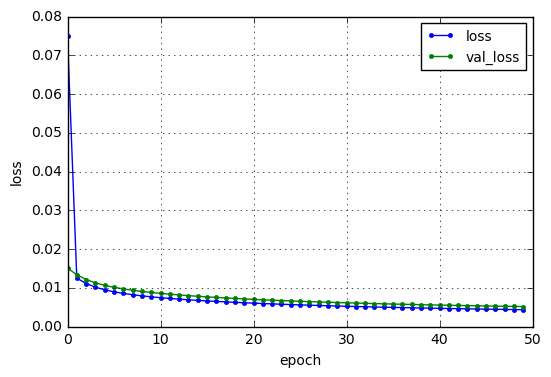

hiden node = 64
_AEdim=064_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.1141 - val_loss: 0.0249
Epoch 2/50
1s - loss: 0.0165 - val_loss: 0.0151
Epoch 3/50
1s - loss: 0.0126 - val_loss: 0.0133
Epoch 4/50
1s - loss: 0.0111 - val_loss: 0.0123
Epoch 5/50
1s - loss: 0.0102 - val_loss: 0.0116
Epoch 6/50
1s - loss: 0.0095 - val_loss: 0.0111
Epoch 7/50
1s - loss: 0.0091 - val_loss: 0.0107
Epoch 8/50
1s - loss: 0.0087 - val_loss: 0.0104
Epoch 9/50
1s - loss: 0.0084 - val_loss: 0.0101
Epoch 10/50
1s - loss: 0.0082 - val_loss: 0.0098
Epoch 11/50
1s - loss: 0.0080 - val_loss: 0.0096
Epoch 12/50
1s - loss: 0.0078 - val_loss: 0.0094
Epoch 13/50
1s - loss: 0.0076 - val_loss: 0.0093
Epoch 14/50
1s - loss: 0.0075 - val_loss: 0.0091
Epoch 15/50
1s - loss: 0.0074 - val_loss: 0.0089
Epoch 16/50
0s - loss: 0.0072 - val_loss: 0.0088
Epoch 17/50
0s - loss: 0.0071 - val_loss: 0.0087
Epoch 18/50
1s - loss: 0.0070 - val_loss: 0.0086
Epoch 19/50
1s - loss: 0.006

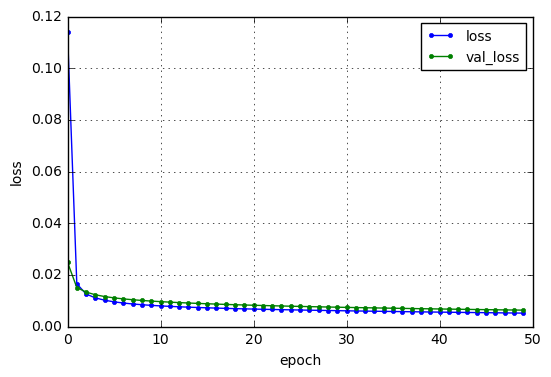

hiden node = 32
_AEdim=032_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.1533 - val_loss: 0.0611
Epoch 2/50
1s - loss: 0.0355 - val_loss: 0.0238
Epoch 3/50
1s - loss: 0.0193 - val_loss: 0.0179
Epoch 4/50
1s - loss: 0.0149 - val_loss: 0.0152
Epoch 5/50
1s - loss: 0.0125 - val_loss: 0.0137
Epoch 6/50
1s - loss: 0.0112 - val_loss: 0.0129
Epoch 7/50
1s - loss: 0.0102 - val_loss: 0.0123
Epoch 8/50
1s - loss: 0.0096 - val_loss: 0.0118
Epoch 9/50
1s - loss: 0.0091 - val_loss: 0.0114
Epoch 10/50
1s - loss: 0.0088 - val_loss: 0.0111
Epoch 11/50
1s - loss: 0.0085 - val_loss: 0.0109
Epoch 12/50
1s - loss: 0.0082 - val_loss: 0.0107
Epoch 13/50
1s - loss: 0.0080 - val_loss: 0.0105
Epoch 14/50
1s - loss: 0.0079 - val_loss: 0.0103
Epoch 15/50
1s - loss: 0.0077 - val_loss: 0.0101
Epoch 16/50
1s - loss: 0.0076 - val_loss: 0.0100
Epoch 17/50
1s - loss: 0.0075 - val_loss: 0.0099
Epoch 18/50
1s - loss: 0.0074 - val_loss: 0.0097
Epoch 19/50
1s - loss: 0.007

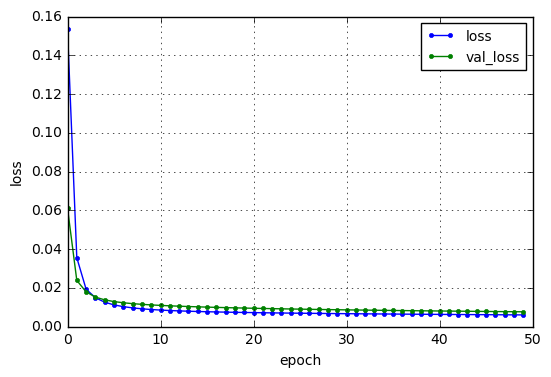

this data had finished making
hiden node = 512
_AEdim=512_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.0860 - val_loss: 0.0193
Epoch 2/50
1s - loss: 0.0165 - val_loss: 0.0161
Epoch 3/50
1s - loss: 0.0150 - val_loss: 0.0151
Epoch 4/50
1s - loss: 0.0141 - val_loss: 0.0143
Epoch 5/50
1s - loss: 0.0133 - val_loss: 0.0136
Epoch 6/50
1s - loss: 0.0127 - val_loss: 0.0129
Epoch 7/50
1s - loss: 0.0121 - val_loss: 0.0124
Epoch 8/50
1s - loss: 0.0116 - val_loss: 0.0119
Epoch 9/50
1s - loss: 0.0112 - val_loss: 0.0115
Epoch 10/50
1s - loss: 0.0108 - val_loss: 0.0111
Epoch 11/50
1s - loss: 0.0105 - val_loss: 0.0107
Epoch 12/50
1s - loss: 0.0101 - val_loss: 0.0104
Epoch 13/50
1s - loss: 0.0098 - val_loss: 0.0101
Epoch 14/50
1s - loss: 0.0096 - val_loss: 0.0099
Epoch 15/50
1s - loss: 0.0093 - val_loss: 0.0096
Epoch 16/50
1s - loss: 0.0091 - val_loss: 0.0094
Epoch 17/50
1s - loss: 0.0089 - val_loss: 0.0092
Epoch 18/50
1s - loss: 0.0087 - val_loss: 0.00

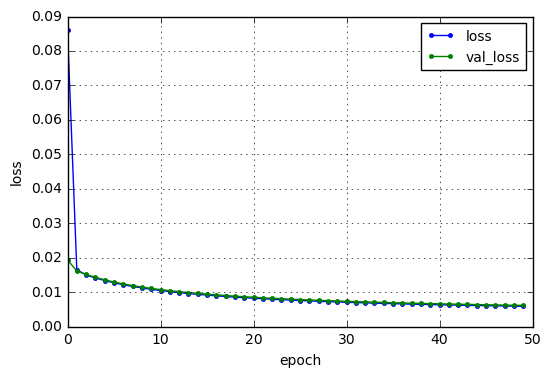

hiden node = 256
_AEdim=256_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.1369 - val_loss: 0.0388
Epoch 2/50
1s - loss: 0.0241 - val_loss: 0.0185
Epoch 3/50
1s - loss: 0.0170 - val_loss: 0.0168
Epoch 4/50
1s - loss: 0.0158 - val_loss: 0.0159
Epoch 5/50
1s - loss: 0.0149 - val_loss: 0.0150
Epoch 6/50
1s - loss: 0.0142 - val_loss: 0.0144
Epoch 7/50
1s - loss: 0.0136 - val_loss: 0.0138
Epoch 8/50
1s - loss: 0.0131 - val_loss: 0.0133
Epoch 9/50
1s - loss: 0.0126 - val_loss: 0.0129
Epoch 10/50
1s - loss: 0.0122 - val_loss: 0.0125
Epoch 11/50
1s - loss: 0.0119 - val_loss: 0.0122
Epoch 12/50
1s - loss: 0.0116 - val_loss: 0.0119
Epoch 13/50
1s - loss: 0.0113 - val_loss: 0.0116
Epoch 14/50
1s - loss: 0.0110 - val_loss: 0.0114
Epoch 15/50
1s - loss: 0.0108 - val_loss: 0.0112
Epoch 16/50
1s - loss: 0.0106 - val_loss: 0.0110
Epoch 17/50
1s - loss: 0.0104 - val_loss: 0.0108
Epoch 18/50
1s - loss: 0.0102 - val_loss: 0.0106
Epoch 19/50
1s - loss: 0.01

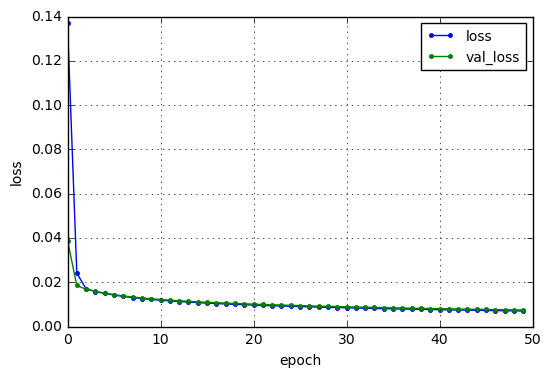

hiden node = 128
_AEdim=128_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.1810 - val_loss: 0.0850
Epoch 2/50
1s - loss: 0.0492 - val_loss: 0.0288
Epoch 3/50
0s - loss: 0.0229 - val_loss: 0.0199
Epoch 4/50
0s - loss: 0.0183 - val_loss: 0.0178
Epoch 5/50
0s - loss: 0.0167 - val_loss: 0.0166
Epoch 6/50
0s - loss: 0.0157 - val_loss: 0.0157
Epoch 7/50
0s - loss: 0.0149 - val_loss: 0.0150
Epoch 8/50
0s - loss: 0.0142 - val_loss: 0.0144
Epoch 9/50
0s - loss: 0.0137 - val_loss: 0.0140
Epoch 10/50
0s - loss: 0.0132 - val_loss: 0.0136
Epoch 11/50
0s - loss: 0.0128 - val_loss: 0.0132
Epoch 12/50
0s - loss: 0.0125 - val_loss: 0.0130
Epoch 13/50
1s - loss: 0.0122 - val_loss: 0.0127
Epoch 14/50
0s - loss: 0.0119 - val_loss: 0.0125
Epoch 15/50
1s - loss: 0.0117 - val_loss: 0.0123
Epoch 16/50
0s - loss: 0.0115 - val_loss: 0.0121
Epoch 17/50
1s - loss: 0.0113 - val_loss: 0.0119
Epoch 18/50
0s - loss: 0.0111 - val_loss: 0.0117
Epoch 19/50
0s - loss: 0.01

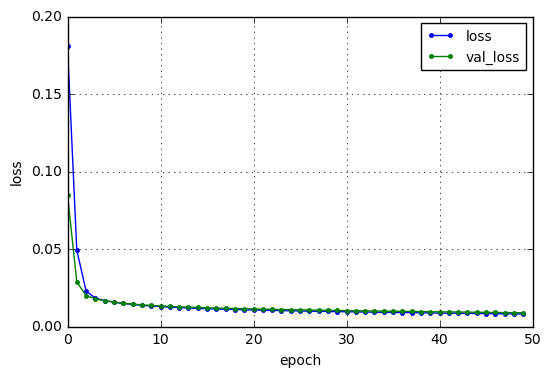

hiden node = 64
_AEdim=064_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2335 - val_loss: 0.1677
Epoch 2/50
0s - loss: 0.1162 - val_loss: 0.0747
Epoch 3/50
0s - loss: 0.0527 - val_loss: 0.0375
Epoch 4/50
0s - loss: 0.0304 - val_loss: 0.0257
Epoch 5/50
0s - loss: 0.0230 - val_loss: 0.0213
Epoch 6/50
0s - loss: 0.0197 - val_loss: 0.0190
Epoch 7/50
0s - loss: 0.0178 - val_loss: 0.0175
Epoch 8/50
0s - loss: 0.0165 - val_loss: 0.0164
Epoch 9/50
0s - loss: 0.0155 - val_loss: 0.0157
Epoch 10/50
0s - loss: 0.0148 - val_loss: 0.0151
Epoch 11/50
0s - loss: 0.0142 - val_loss: 0.0146
Epoch 12/50
0s - loss: 0.0137 - val_loss: 0.0143
Epoch 13/50
0s - loss: 0.0133 - val_loss: 0.0140
Epoch 14/50
0s - loss: 0.0130 - val_loss: 0.0137
Epoch 15/50
0s - loss: 0.0127 - val_loss: 0.0135
Epoch 16/50
0s - loss: 0.0124 - val_loss: 0.0133
Epoch 17/50
0s - loss: 0.0122 - val_loss: 0.0131
Epoch 18/50
0s - loss: 0.0120 - val_loss: 0.0129
Epoch 19/50
0s - loss: 0.011

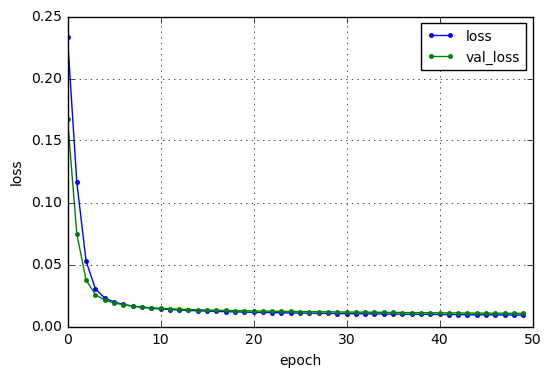

this data had finished making
hiden node = 1024
_AEdim=1024_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.1706 - val_loss: 0.0598
Epoch 2/50
0s - loss: 0.0386 - val_loss: 0.0278
Epoch 3/50
0s - loss: 0.0251 - val_loss: 0.0237
Epoch 4/50
0s - loss: 0.0228 - val_loss: 0.0223
Epoch 5/50
0s - loss: 0.0216 - val_loss: 0.0213
Epoch 6/50
0s - loss: 0.0207 - val_loss: 0.0204
Epoch 7/50
0s - loss: 0.0198 - val_loss: 0.0196
Epoch 8/50
0s - loss: 0.0191 - val_loss: 0.0188
Epoch 9/50
0s - loss: 0.0184 - val_loss: 0.0182
Epoch 10/50
0s - loss: 0.0178 - val_loss: 0.0176
Epoch 11/50
0s - loss: 0.0172 - val_loss: 0.0171
Epoch 12/50
0s - loss: 0.0167 - val_loss: 0.0166
Epoch 13/50
0s - loss: 0.0162 - val_loss: 0.0161
Epoch 14/50
0s - loss: 0.0158 - val_loss: 0.0157
Epoch 15/50
0s - loss: 0.0154 - val_loss: 0.0153
Epoch 16/50
0s - loss: 0.0150 - val_loss: 0.0149
Epoch 17/50
0s - loss: 0.0147 - val_loss: 0.0146
Epoch 18/50
0s - loss: 0.0143 - val_loss: 0.01

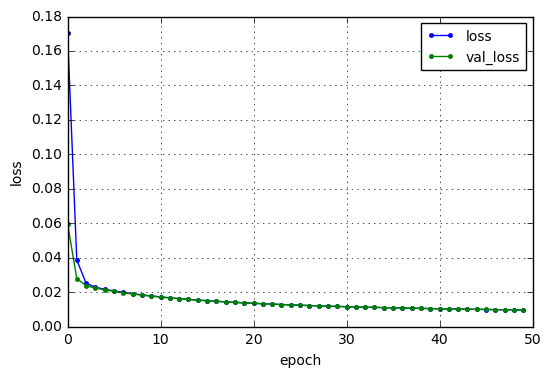

hiden node = 512
_AEdim=512_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2122 - val_loss: 0.1129
Epoch 2/50
0s - loss: 0.0743 - val_loss: 0.0477
Epoch 3/50
0s - loss: 0.0366 - val_loss: 0.0294
Epoch 4/50
0s - loss: 0.0265 - val_loss: 0.0246
Epoch 5/50
0s - loss: 0.0236 - val_loss: 0.0229
Epoch 6/50
0s - loss: 0.0223 - val_loss: 0.0219
Epoch 7/50
0s - loss: 0.0214 - val_loss: 0.0212
Epoch 8/50
0s - loss: 0.0207 - val_loss: 0.0205
Epoch 9/50
0s - loss: 0.0201 - val_loss: 0.0199
Epoch 10/50
0s - loss: 0.0195 - val_loss: 0.0193
Epoch 11/50
0s - loss: 0.0189 - val_loss: 0.0188
Epoch 12/50
0s - loss: 0.0184 - val_loss: 0.0183
Epoch 13/50
0s - loss: 0.0180 - val_loss: 0.0179
Epoch 14/50
0s - loss: 0.0176 - val_loss: 0.0175
Epoch 15/50
0s - loss: 0.0172 - val_loss: 0.0171
Epoch 16/50
0s - loss: 0.0168 - val_loss: 0.0167
Epoch 17/50
0s - loss: 0.0165 - val_loss: 0.0164
Epoch 18/50
0s - loss: 0.0161 - val_loss: 0.0161
Epoch 19/50
0s - loss: 0.0158

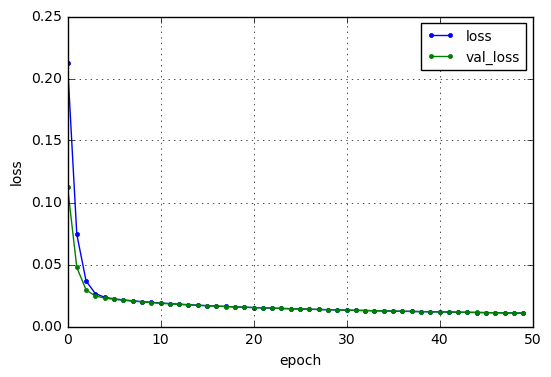

hiden node = 256
_AEdim=256_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2489 - val_loss: 0.1759
Epoch 2/50
0s - loss: 0.1326 - val_loss: 0.0954
Epoch 3/50
0s - loss: 0.0716 - val_loss: 0.0529
Epoch 4/50
0s - loss: 0.0427 - val_loss: 0.0351
Epoch 5/50
0s - loss: 0.0311 - val_loss: 0.0281
Epoch 6/50
0s - loss: 0.0265 - val_loss: 0.0252
Epoch 7/50
0s - loss: 0.0244 - val_loss: 0.0238
Epoch 8/50
0s - loss: 0.0232 - val_loss: 0.0228
Epoch 9/50
0s - loss: 0.0224 - val_loss: 0.0221
Epoch 10/50
0s - loss: 0.0217 - val_loss: 0.0215
Epoch 11/50
0s - loss: 0.0211 - val_loss: 0.0210
Epoch 12/50
0s - loss: 0.0206 - val_loss: 0.0205
Epoch 13/50
0s - loss: 0.0202 - val_loss: 0.0200
Epoch 14/50
0s - loss: 0.0197 - val_loss: 0.0196
Epoch 15/50
0s - loss: 0.0194 - val_loss: 0.0193
Epoch 16/50
0s - loss: 0.0190 - val_loss: 0.0189
Epoch 17/50
0s - loss: 0.0187 - val_loss: 0.0186
Epoch 18/50
0s - loss: 0.0184 - val_loss: 0.0183
Epoch 19/50
0s - loss: 0.0181

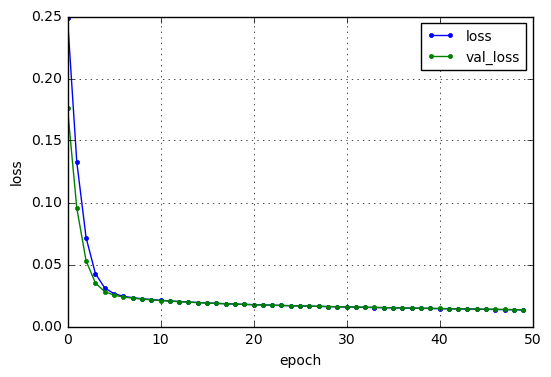

hiden node = 128
_AEdim=128_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2784 - val_loss: 0.2359
Epoch 2/50
0s - loss: 0.2064 - val_loss: 0.1768
Epoch 3/50
0s - loss: 0.1492 - val_loss: 0.1232
Epoch 4/50
0s - loss: 0.1025 - val_loss: 0.0841
Epoch 5/50
0s - loss: 0.0708 - val_loss: 0.0595
Epoch 6/50
0s - loss: 0.0518 - val_loss: 0.0453
Epoch 7/50
0s - loss: 0.0408 - val_loss: 0.0371
Epoch 8/50
0s - loss: 0.0346 - val_loss: 0.0324
Epoch 9/50
0s - loss: 0.0308 - val_loss: 0.0295
Epoch 10/50
0s - loss: 0.0284 - val_loss: 0.0275
Epoch 11/50
0s - loss: 0.0267 - val_loss: 0.0260
Epoch 12/50
0s - loss: 0.0254 - val_loss: 0.0249
Epoch 13/50
0s - loss: 0.0243 - val_loss: 0.0239
Epoch 14/50
0s - loss: 0.0234 - val_loss: 0.0231
Epoch 15/50
0s - loss: 0.0227 - val_loss: 0.0224
Epoch 16/50
0s - loss: 0.0220 - val_loss: 0.0218
Epoch 17/50
0s - loss: 0.0215 - val_loss: 0.0213
Epoch 18/50
0s - loss: 0.0210 - val_loss: 0.0209
Epoch 19/50
0s - loss: 0.0206

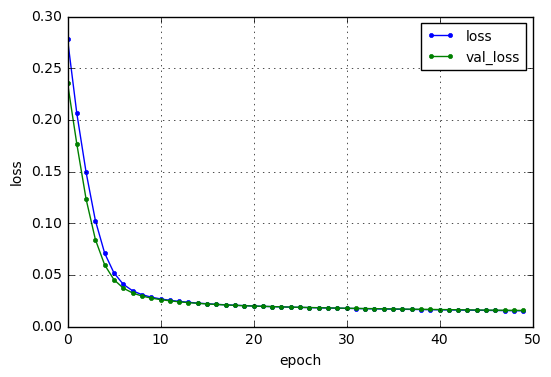

this data had finished making
hiden node = 2048
_AEdim=2048_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2547 - val_loss: 0.1425
Epoch 2/50
0s - loss: 0.1011 - val_loss: 0.0721
Epoch 3/50
0s - loss: 0.0585 - val_loss: 0.0486
Epoch 4/50
0s - loss: 0.0436 - val_loss: 0.0399
Epoch 5/50
0s - loss: 0.0378 - val_loss: 0.0361
Epoch 6/50
0s - loss: 0.0351 - val_loss: 0.0341
Epoch 7/50
0s - loss: 0.0334 - val_loss: 0.0327
Epoch 8/50
0s - loss: 0.0321 - val_loss: 0.0316
Epoch 9/50
0s - loss: 0.0310 - val_loss: 0.0305
Epoch 10/50
0s - loss: 0.0301 - val_loss: 0.0296
Epoch 11/50
0s - loss: 0.0292 - val_loss: 0.0288
Epoch 12/50
0s - loss: 0.0284 - val_loss: 0.0280
Epoch 13/50
0s - loss: 0.0276 - val_loss: 0.0273
Epoch 14/50
0s - loss: 0.0269 - val_loss: 0.0266
Epoch 15/50
0s - loss: 0.0262 - val_loss: 0.0259
Epoch 16/50
0s - loss: 0.0256 - val_loss: 0.0253
Epoch 17/50
0s - loss: 0.0250 - val_loss: 0.0247
Epoch 18/50
0s - loss: 0.0245 - val_loss: 0.02

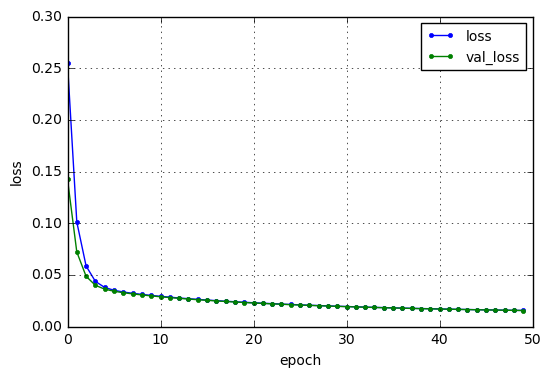

hiden node = 1024
_AEdim=1024_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2881 - val_loss: 0.2051
Epoch 2/50
0s - loss: 0.1624 - val_loss: 0.1274
Epoch 3/50
0s - loss: 0.1043 - val_loss: 0.0846
Epoch 4/50
0s - loss: 0.0716 - val_loss: 0.0606
Epoch 5/50
0s - loss: 0.0536 - val_loss: 0.0478
Epoch 6/50
0s - loss: 0.0441 - val_loss: 0.0410
Epoch 7/50
0s - loss: 0.0390 - val_loss: 0.0373
Epoch 8/50
0s - loss: 0.0362 - val_loss: 0.0352
Epoch 9/50
0s - loss: 0.0345 - val_loss: 0.0338
Epoch 10/50
0s - loss: 0.0333 - val_loss: 0.0328
Epoch 11/50
0s - loss: 0.0324 - val_loss: 0.0320
Epoch 12/50
0s - loss: 0.0317 - val_loss: 0.0313
Epoch 13/50
0s - loss: 0.0310 - val_loss: 0.0307
Epoch 14/50
0s - loss: 0.0304 - val_loss: 0.0301
Epoch 15/50
0s - loss: 0.0298 - val_loss: 0.0295
Epoch 16/50
0s - loss: 0.0292 - val_loss: 0.0290
Epoch 17/50
0s - loss: 0.0287 - val_loss: 0.0285
Epoch 18/50
0s - loss: 0.0282 - val_loss: 0.0280
Epoch 19/50
0s - loss: 0.02

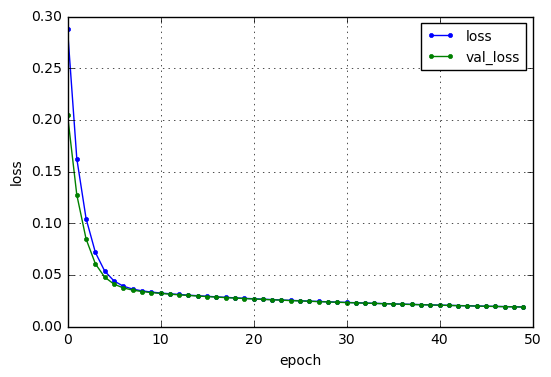

hiden node = 512
_AEdim=512_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2984 - val_loss: 0.2444
Epoch 2/50
0s - loss: 0.2135 - val_loss: 0.1861
Epoch 3/50
0s - loss: 0.1642 - val_loss: 0.1434
Epoch 4/50
0s - loss: 0.1261 - val_loss: 0.1098
Epoch 5/50
0s - loss: 0.0968 - val_loss: 0.0848
Epoch 6/50
0s - loss: 0.0756 - val_loss: 0.0672
Epoch 7/50
0s - loss: 0.0610 - val_loss: 0.0554
Epoch 8/50
0s - loss: 0.0513 - val_loss: 0.0477
Epoch 9/50
0s - loss: 0.0451 - val_loss: 0.0427
Epoch 10/50
0s - loss: 0.0410 - val_loss: 0.0394
Epoch 11/50
0s - loss: 0.0383 - val_loss: 0.0372
Epoch 12/50
0s - loss: 0.0364 - val_loss: 0.0357
Epoch 13/50
0s - loss: 0.0351 - val_loss: 0.0345
Epoch 14/50
0s - loss: 0.0341 - val_loss: 0.0337
Epoch 15/50
0s - loss: 0.0333 - val_loss: 0.0329
Epoch 16/50
0s - loss: 0.0326 - val_loss: 0.0323
Epoch 17/50
0s - loss: 0.0320 - val_loss: 0.0318
Epoch 18/50
0s - loss: 0.0315 - val_loss: 0.0313
Epoch 19/50
0s - loss: 0.0310

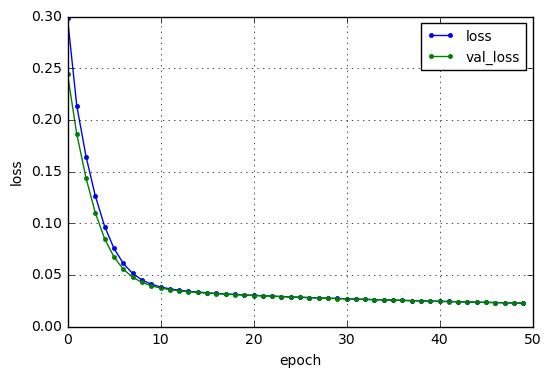

hiden node = 256
_AEdim=256_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2961 - val_loss: 0.2647
Epoch 2/50
0s - loss: 0.2458 - val_loss: 0.2287
Epoch 3/50
0s - loss: 0.2137 - val_loss: 0.1986
Epoch 4/50
0s - loss: 0.1842 - val_loss: 0.1698
Epoch 5/50
0s - loss: 0.1564 - val_loss: 0.1431
Epoch 6/50
0s - loss: 0.1313 - val_loss: 0.1198
Epoch 7/50
0s - loss: 0.1098 - val_loss: 0.1003
Epoch 8/50
0s - loss: 0.0923 - val_loss: 0.0847
Epoch 9/50
0s - loss: 0.0784 - val_loss: 0.0725
Epoch 10/50
0s - loss: 0.0677 - val_loss: 0.0632
Epoch 11/50
0s - loss: 0.0596 - val_loss: 0.0561
Epoch 12/50
0s - loss: 0.0534 - val_loss: 0.0508
Epoch 13/50
0s - loss: 0.0488 - val_loss: 0.0469
Epoch 14/50
0s - loss: 0.0453 - val_loss: 0.0438
Epoch 15/50
0s - loss: 0.0426 - val_loss: 0.0415
Epoch 16/50
0s - loss: 0.0406 - val_loss: 0.0397
Epoch 17/50
0s - loss: 0.0389 - val_loss: 0.0382
Epoch 18/50
0s - loss: 0.0376 - val_loss: 0.0370
Epoch 19/50
0s - loss: 0.0365

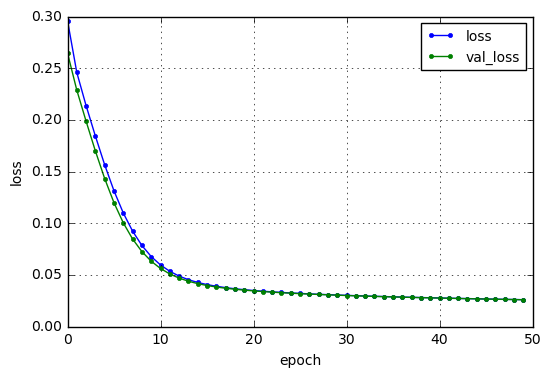

this data had finished making
hiden node = 4096
_AEdim=4096_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
1s - loss: 0.3394 - val_loss: 0.2512
Epoch 2/50
1s - loss: 0.2042 - val_loss: 0.1649
Epoch 3/50
1s - loss: 0.1408 - val_loss: 0.1195
Epoch 4/50
1s - loss: 0.1056 - val_loss: 0.0931
Epoch 5/50
1s - loss: 0.0847 - val_loss: 0.0770
Epoch 6/50
1s - loss: 0.0718 - val_loss: 0.0670
Epoch 7/50
1s - loss: 0.0637 - val_loss: 0.0606
Epoch 8/50
1s - loss: 0.0584 - val_loss: 0.0563
Epoch 9/50
1s - loss: 0.0548 - val_loss: 0.0534
Epoch 10/50
1s - loss: 0.0523 - val_loss: 0.0512
Epoch 11/50
1s - loss: 0.0504 - val_loss: 0.0495
Epoch 12/50
1s - loss: 0.0488 - val_loss: 0.0481
Epoch 13/50
1s - loss: 0.0475 - val_loss: 0.0469
Epoch 14/50
1s - loss: 0.0463 - val_loss: 0.0458
Epoch 15/50
1s - loss: 0.0453 - val_loss: 0.0448
Epoch 16/50
1s - loss: 0.0444 - val_loss: 0.0439
Epoch 17/50
1s - loss: 0.0435 - val_loss: 0.0430
Epoch 18/50
1s - loss: 0.0426 - val_loss: 0.04

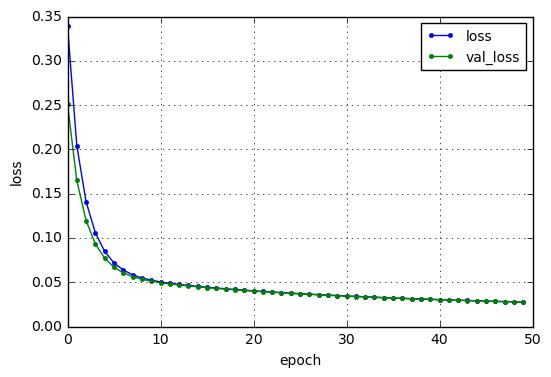

hiden node = 2048
_AEdim=2048_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3452 - val_loss: 0.2859
Epoch 2/50
0s - loss: 0.2504 - val_loss: 0.2190
Epoch 3/50
0s - loss: 0.1972 - val_loss: 0.1767
Epoch 4/50
0s - loss: 0.1610 - val_loss: 0.1459
Epoch 5/50
0s - loss: 0.1339 - val_loss: 0.1222
Epoch 6/50
0s - loss: 0.1130 - val_loss: 0.1039
Epoch 7/50
0s - loss: 0.0968 - val_loss: 0.0898
Epoch 8/50
0s - loss: 0.0844 - val_loss: 0.0791
Epoch 9/50
0s - loss: 0.0750 - val_loss: 0.0710
Epoch 10/50
0s - loss: 0.0679 - val_loss: 0.0649
Epoch 11/50
0s - loss: 0.0626 - val_loss: 0.0603
Epoch 12/50
0s - loss: 0.0586 - val_loss: 0.0569
Epoch 13/50
0s - loss: 0.0556 - val_loss: 0.0543
Epoch 14/50
0s - loss: 0.0533 - val_loss: 0.0523
Epoch 15/50
0s - loss: 0.0515 - val_loss: 0.0507
Epoch 16/50
0s - loss: 0.0501 - val_loss: 0.0494
Epoch 17/50
0s - loss: 0.0489 - val_loss: 0.0483
Epoch 18/50
0s - loss: 0.0479 - val_loss: 0.0474
Epoch 19/50
0s - loss: 0.04

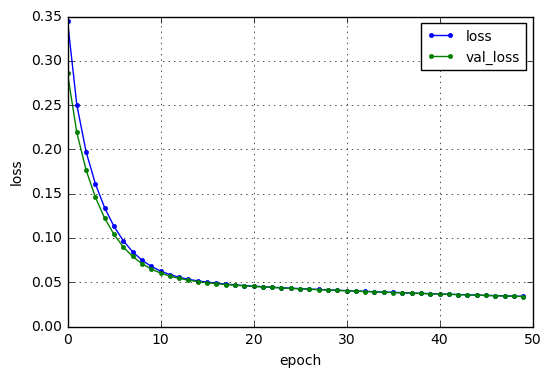

hiden node = 1024
_AEdim=1024_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3414 - val_loss: 0.3042
Epoch 2/50
0s - loss: 0.2801 - val_loss: 0.2582
Epoch 3/50
0s - loss: 0.2423 - val_loss: 0.2271
Epoch 4/50
0s - loss: 0.2148 - val_loss: 0.2025
Epoch 5/50
0s - loss: 0.1920 - val_loss: 0.1812
Epoch 6/50
0s - loss: 0.1717 - val_loss: 0.1620
Epoch 7/50
0s - loss: 0.1535 - val_loss: 0.1448
Epoch 8/50
0s - loss: 0.1372 - val_loss: 0.1294
Epoch 9/50
0s - loss: 0.1227 - val_loss: 0.1159
Epoch 10/50
0s - loss: 0.1101 - val_loss: 0.1042
Epoch 11/50
0s - loss: 0.0992 - val_loss: 0.0942
Epoch 12/50
0s - loss: 0.0900 - val_loss: 0.0858
Epoch 13/50
0s - loss: 0.0823 - val_loss: 0.0788
Epoch 14/50
0s - loss: 0.0759 - val_loss: 0.0730
Epoch 15/50
0s - loss: 0.0706 - val_loss: 0.0682
Epoch 16/50
0s - loss: 0.0663 - val_loss: 0.0643
Epoch 17/50
0s - loss: 0.0627 - val_loss: 0.0611
Epoch 18/50
0s - loss: 0.0598 - val_loss: 0.0585
Epoch 19/50
0s - loss: 0.05

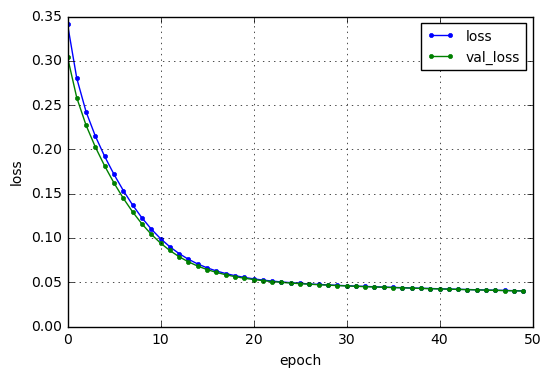

hiden node = 512
_AEdim=512_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3239 - val_loss: 0.3027
Epoch 2/50
0s - loss: 0.2884 - val_loss: 0.2754
Epoch 3/50
0s - loss: 0.2658 - val_loss: 0.2566
Epoch 4/50
0s - loss: 0.2490 - val_loss: 0.2412
Epoch 5/50
0s - loss: 0.2343 - val_loss: 0.2270
Epoch 6/50
0s - loss: 0.2202 - val_loss: 0.2130
Epoch 7/50
0s - loss: 0.2064 - val_loss: 0.1993
Epoch 8/50
0s - loss: 0.1927 - val_loss: 0.1857
Epoch 9/50
0s - loss: 0.1793 - val_loss: 0.1726
Epoch 10/50
0s - loss: 0.1664 - val_loss: 0.1599
Epoch 11/50
0s - loss: 0.1541 - val_loss: 0.1480
Epoch 12/50
0s - loss: 0.1426 - val_loss: 0.1369
Epoch 13/50
0s - loss: 0.1319 - val_loss: 0.1267
Epoch 14/50
0s - loss: 0.1221 - val_loss: 0.1173
Epoch 15/50
0s - loss: 0.1132 - val_loss: 0.1089
Epoch 16/50
0s - loss: 0.1052 - val_loss: 0.1014
Epoch 17/50
0s - loss: 0.0981 - val_loss: 0.0947
Epoch 18/50
0s - loss: 0.0918 - val_loss: 0.0888
Epoch 19/50
0s - loss: 0.0862

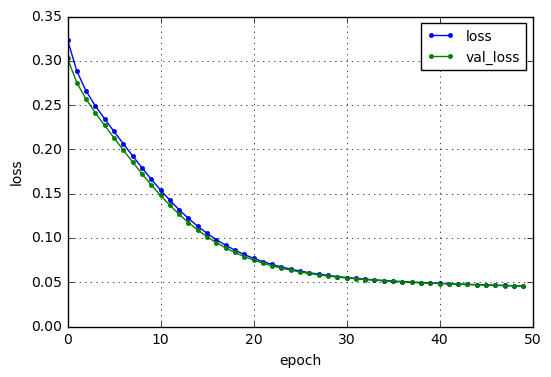

In [109]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
#AEDimention = WindowWidth, WindowWidth/2, WindowWidth/4, WindowWidth/8

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
        
    AEDimentionS=np.array([WindowNum,WindowNum/2,WindowNum/4,WindowNum/8])

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
    
    for AEDimention in AEDimentionS:
        print "hiden node = "+str(AEDimention)
            
        CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
        print CommonName
      
        AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)

上の結果を見る限り，いい感じに学習できていることがわかった．興味として，上記の中間層の次元以外のパラメータを固定して，さらに次元を圧縮してみる．具体的には，1/8より圧縮してみる．



this data had finished making
hiden node = 32
_AEdim=032_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
3s - loss: 0.1475 - val_loss: 0.0492
Epoch 2/50
3s - loss: 0.0282 - val_loss: 0.0200
Epoch 3/50
3s - loss: 0.0164 - val_loss: 0.0160
Epoch 4/50
3s - loss: 0.0133 - val_loss: 0.0140
Epoch 5/50
3s - loss: 0.0116 - val_loss: 0.0129
Epoch 6/50
3s - loss: 0.0105 - val_loss: 0.0122
Epoch 7/50
3s - loss: 0.0098 - val_loss: 0.0117
Epoch 8/50
3s - loss: 0.0093 - val_loss: 0.0114
Epoch 9/50
3s - loss: 0.0089 - val_loss: 0.0111
Epoch 10/50
3s - loss: 0.0086 - val_loss: 0.0108
Epoch 11/50
3s - loss: 0.0083 - val_loss: 0.0106
Epoch 12/50
3s - loss: 0.0081 - val_loss: 0.0104
Epoch 13/50
1s - loss: 0.0079 - val_loss: 0.0102
Epoch 14/50
1s - loss: 0.0078 - val_loss: 0.0101
Epoch 15/50
1s - loss: 0.0076 - val_loss: 0.0099
Epoch 16/50
1s - loss: 0.0075 - val_loss: 0.0098
Epoch 17/50
1s - loss: 0.0074 - val_loss: 0.0097
Epoch 18/50
1s - loss: 0.0073 - val_loss: 0.009

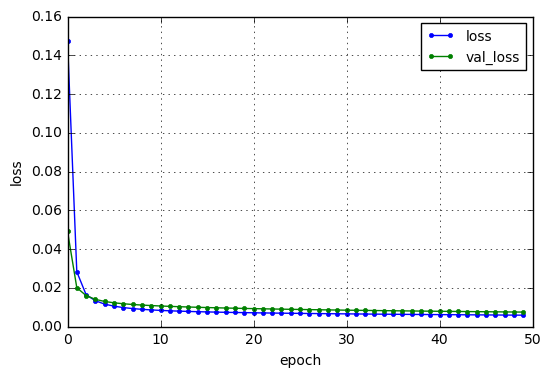

hiden node = 16
_AEdim=016_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.2228 - val_loss: 0.1318
Epoch 2/50
1s - loss: 0.0762 - val_loss: 0.0427
Epoch 3/50
1s - loss: 0.0313 - val_loss: 0.0251
Epoch 4/50
1s - loss: 0.0210 - val_loss: 0.0195
Epoch 5/50
1s - loss: 0.0165 - val_loss: 0.0168
Epoch 6/50
1s - loss: 0.0141 - val_loss: 0.0152
Epoch 7/50
1s - loss: 0.0125 - val_loss: 0.0142
Epoch 8/50
1s - loss: 0.0114 - val_loss: 0.0135
Epoch 9/50
1s - loss: 0.0106 - val_loss: 0.0130
Epoch 10/50
1s - loss: 0.0100 - val_loss: 0.0126
Epoch 11/50
1s - loss: 0.0096 - val_loss: 0.0123
Epoch 12/50
1s - loss: 0.0092 - val_loss: 0.0121
Epoch 13/50
1s - loss: 0.0089 - val_loss: 0.0118
Epoch 14/50
1s - loss: 0.0087 - val_loss: 0.0116
Epoch 15/50
0s - loss: 0.0085 - val_loss: 0.0114
Epoch 16/50
0s - loss: 0.0083 - val_loss: 0.0113
Epoch 17/50
2s - loss: 0.0082 - val_loss: 0.0111
Epoch 18/50
4s - loss: 0.0080 - val_loss: 0.0110
Epoch 19/50
4s - loss: 0.007

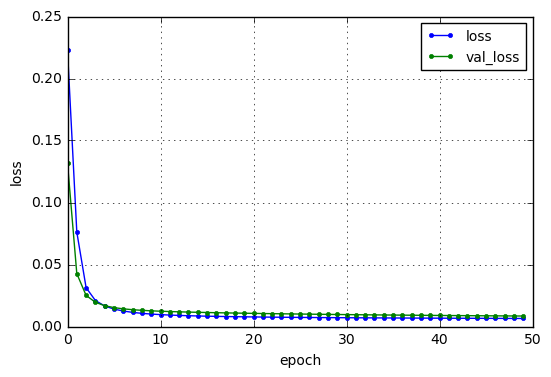

hiden node = 8
_AEdim=008_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
3s - loss: 0.2530 - val_loss: 0.2004
Epoch 2/50
2s - loss: 0.1424 - val_loss: 0.0953
Epoch 3/50
2s - loss: 0.0702 - val_loss: 0.0524
Epoch 4/50
2s - loss: 0.0429 - val_loss: 0.0360
Epoch 5/50
2s - loss: 0.0310 - val_loss: 0.0278
Epoch 6/50
2s - loss: 0.0242 - val_loss: 0.0230
Epoch 7/50
2s - loss: 0.0199 - val_loss: 0.0200
Epoch 8/50
2s - loss: 0.0170 - val_loss: 0.0180
Epoch 9/50
2s - loss: 0.0150 - val_loss: 0.0165
Epoch 10/50
2s - loss: 0.0136 - val_loss: 0.0155
Epoch 11/50
2s - loss: 0.0125 - val_loss: 0.0148
Epoch 12/50
2s - loss: 0.0117 - val_loss: 0.0142
Epoch 13/50
0s - loss: 0.0111 - val_loss: 0.0138
Epoch 14/50
0s - loss: 0.0106 - val_loss: 0.0135
Epoch 15/50
1s - loss: 0.0102 - val_loss: 0.0132
Epoch 16/50
2s - loss: 0.0098 - val_loss: 0.0129
Epoch 17/50
2s - loss: 0.0095 - val_loss: 0.0127
Epoch 18/50
2s - loss: 0.0093 - val_loss: 0.0125
Epoch 19/50
2s - loss: 0.0091

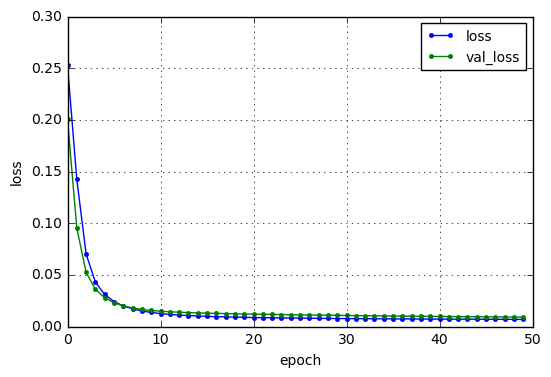

hiden node = 4
_AEdim=004_Win=0256_Sld=0032_sgd
Train on 33676 samples, validate on 33676 samples
Epoch 1/50
1s - loss: 0.2395 - val_loss: 0.1925
Epoch 2/50
1s - loss: 0.1538 - val_loss: 0.1214
Epoch 3/50
1s - loss: 0.0998 - val_loss: 0.0822
Epoch 4/50
1s - loss: 0.0703 - val_loss: 0.0604
Epoch 5/50
1s - loss: 0.0532 - val_loss: 0.0471
Epoch 6/50
1s - loss: 0.0420 - val_loss: 0.0383
Epoch 7/50
1s - loss: 0.0343 - val_loss: 0.0321
Epoch 8/50
1s - loss: 0.0287 - val_loss: 0.0276
Epoch 9/50
1s - loss: 0.0245 - val_loss: 0.0243
Epoch 10/50
0s - loss: 0.0214 - val_loss: 0.0219
Epoch 11/50
0s - loss: 0.0191 - val_loss: 0.0201
Epoch 12/50
0s - loss: 0.0173 - val_loss: 0.0186
Epoch 13/50
4s - loss: 0.0159 - val_loss: 0.0176
Epoch 14/50
5s - loss: 0.0148 - val_loss: 0.0167
Epoch 15/50
5s - loss: 0.0139 - val_loss: 0.0160
Epoch 16/50
5s - loss: 0.0131 - val_loss: 0.0155
Epoch 17/50
5s - loss: 0.0125 - val_loss: 0.0151
Epoch 18/50
5s - loss: 0.0120 - val_loss: 0.0147
Epoch 19/50
5s - loss: 0.0115

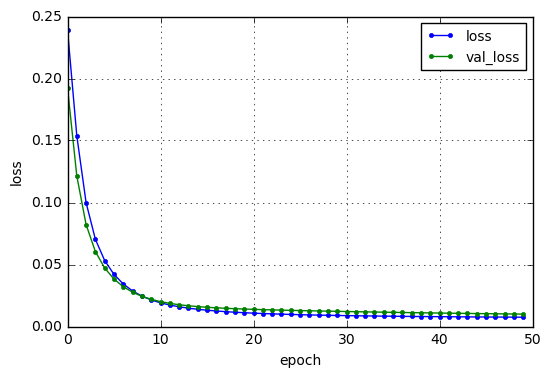

this data had finished making
hiden node = 64
_AEdim=064_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
2s - loss: 0.2281 - val_loss: 0.1586
Epoch 2/50
2s - loss: 0.1094 - val_loss: 0.0705
Epoch 3/50
2s - loss: 0.0503 - val_loss: 0.0364
Epoch 4/50
2s - loss: 0.0299 - val_loss: 0.0255
Epoch 5/50
2s - loss: 0.0229 - val_loss: 0.0214
Epoch 6/50
2s - loss: 0.0198 - val_loss: 0.0191
Epoch 7/50
2s - loss: 0.0179 - val_loss: 0.0176
Epoch 8/50
2s - loss: 0.0166 - val_loss: 0.0166
Epoch 9/50
2s - loss: 0.0156 - val_loss: 0.0158
Epoch 10/50
2s - loss: 0.0149 - val_loss: 0.0152
Epoch 11/50
2s - loss: 0.0143 - val_loss: 0.0147
Epoch 12/50
2s - loss: 0.0138 - val_loss: 0.0143
Epoch 13/50
2s - loss: 0.0134 - val_loss: 0.0140
Epoch 14/50
2s - loss: 0.0130 - val_loss: 0.0137
Epoch 15/50
2s - loss: 0.0127 - val_loss: 0.0135
Epoch 16/50
2s - loss: 0.0124 - val_loss: 0.0133
Epoch 17/50
2s - loss: 0.0122 - val_loss: 0.0131
Epoch 18/50
2s - loss: 0.0120 - val_loss: 0.013

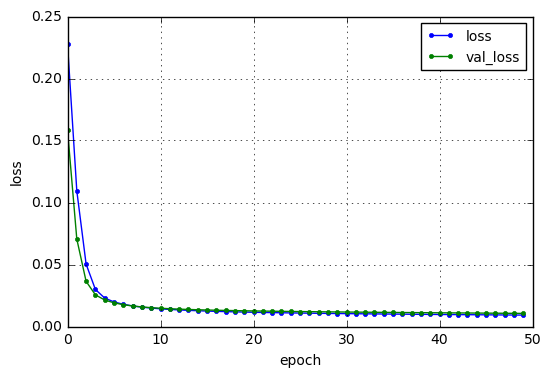

hiden node = 32
_AEdim=032_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
1s - loss: 0.2582 - val_loss: 0.2154
Epoch 2/50
1s - loss: 0.1730 - val_loss: 0.1327
Epoch 3/50
1s - loss: 0.1024 - val_loss: 0.0775
Epoch 4/50
1s - loss: 0.0620 - val_loss: 0.0498
Epoch 5/50
1s - loss: 0.0423 - val_loss: 0.0365
Epoch 6/50
1s - loss: 0.0326 - val_loss: 0.0296
Epoch 7/50
1s - loss: 0.0272 - val_loss: 0.0254
Epoch 8/50
1s - loss: 0.0237 - val_loss: 0.0226
Epoch 9/50
1s - loss: 0.0212 - val_loss: 0.0207
Epoch 10/50
1s - loss: 0.0195 - val_loss: 0.0193
Epoch 11/50
1s - loss: 0.0182 - val_loss: 0.0182
Epoch 12/50
1s - loss: 0.0171 - val_loss: 0.0174
Epoch 13/50
1s - loss: 0.0163 - val_loss: 0.0168
Epoch 14/50
1s - loss: 0.0156 - val_loss: 0.0163
Epoch 15/50
1s - loss: 0.0151 - val_loss: 0.0158
Epoch 16/50
1s - loss: 0.0146 - val_loss: 0.0155
Epoch 17/50
1s - loss: 0.0142 - val_loss: 0.0152
Epoch 18/50
1s - loss: 0.0138 - val_loss: 0.0149
Epoch 19/50
1s - loss: 0.013

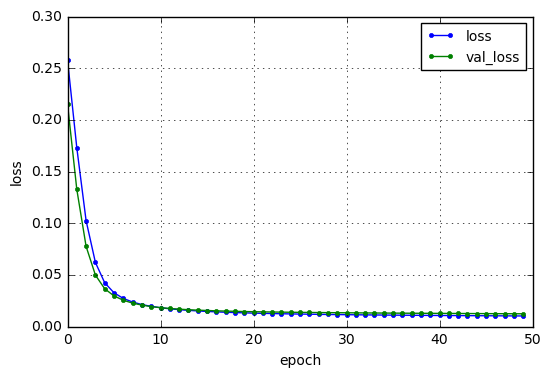

hiden node = 16
_AEdim=016_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2666 - val_loss: 0.2406
Epoch 2/50
0s - loss: 0.2134 - val_loss: 0.1857
Epoch 3/50
0s - loss: 0.1600 - val_loss: 0.1361
Epoch 4/50
0s - loss: 0.1167 - val_loss: 0.0993
Epoch 5/50
0s - loss: 0.0862 - val_loss: 0.0746
Epoch 6/50
0s - loss: 0.0660 - val_loss: 0.0586
Epoch 7/50
0s - loss: 0.0529 - val_loss: 0.0480
Epoch 8/50
0s - loss: 0.0440 - val_loss: 0.0406
Epoch 9/50
0s - loss: 0.0377 - val_loss: 0.0353
Epoch 10/50
0s - loss: 0.0331 - val_loss: 0.0314
Epoch 11/50
0s - loss: 0.0296 - val_loss: 0.0284
Epoch 12/50
0s - loss: 0.0268 - val_loss: 0.0261
Epoch 13/50
0s - loss: 0.0247 - val_loss: 0.0243
Epoch 14/50
0s - loss: 0.0230 - val_loss: 0.0229
Epoch 15/50
0s - loss: 0.0216 - val_loss: 0.0217
Epoch 16/50
0s - loss: 0.0204 - val_loss: 0.0208
Epoch 17/50
0s - loss: 0.0194 - val_loss: 0.0200
Epoch 18/50
0s - loss: 0.0185 - val_loss: 0.0193
Epoch 19/50
0s - loss: 0.017

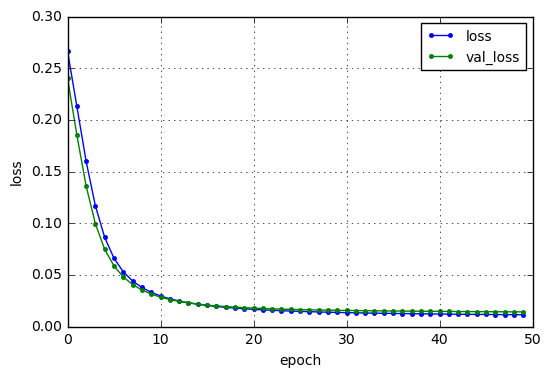

hiden node = 8
_AEdim=008_Win=0512_Sld=0064_sgd
Train on 16834 samples, validate on 16834 samples
Epoch 1/50
0s - loss: 0.2771 - val_loss: 0.2608
Epoch 2/50
0s - loss: 0.2417 - val_loss: 0.2218
Epoch 3/50
0s - loss: 0.2023 - val_loss: 0.1835
Epoch 4/50
0s - loss: 0.1668 - val_loss: 0.1511
Epoch 5/50
0s - loss: 0.1375 - val_loss: 0.1248
Epoch 6/50
0s - loss: 0.1140 - val_loss: 0.1040
Epoch 7/50
0s - loss: 0.0957 - val_loss: 0.0880
Epoch 8/50
0s - loss: 0.0816 - val_loss: 0.0757
Epoch 9/50
0s - loss: 0.0708 - val_loss: 0.0662
Epoch 10/50
0s - loss: 0.0622 - val_loss: 0.0586
Epoch 11/50
0s - loss: 0.0554 - val_loss: 0.0524
Epoch 12/50
0s - loss: 0.0497 - val_loss: 0.0473
Epoch 13/50
0s - loss: 0.0451 - val_loss: 0.0431
Epoch 14/50
0s - loss: 0.0412 - val_loss: 0.0396
Epoch 15/50
0s - loss: 0.0379 - val_loss: 0.0367
Epoch 16/50
0s - loss: 0.0351 - val_loss: 0.0342
Epoch 17/50
0s - loss: 0.0327 - val_loss: 0.0320
Epoch 18/50
0s - loss: 0.0306 - val_loss: 0.0302
Epoch 19/50
0s - loss: 0.0288

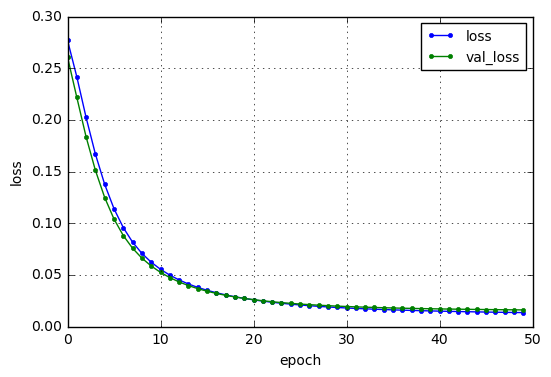

this data had finished making
hiden node = 128
_AEdim=128_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2767 - val_loss: 0.2315
Epoch 2/50
0s - loss: 0.1995 - val_loss: 0.1680
Epoch 3/50
0s - loss: 0.1399 - val_loss: 0.1139
Epoch 4/50
0s - loss: 0.0938 - val_loss: 0.0763
Epoch 5/50
0s - loss: 0.0641 - val_loss: 0.0538
Epoch 6/50
0s - loss: 0.0470 - val_loss: 0.0413
Epoch 7/50
0s - loss: 0.0375 - val_loss: 0.0344
Epoch 8/50
0s - loss: 0.0322 - val_loss: 0.0305
Epoch 9/50
0s - loss: 0.0291 - val_loss: 0.0280
Epoch 10/50
0s - loss: 0.0270 - val_loss: 0.0263
Epoch 11/50
0s - loss: 0.0256 - val_loss: 0.0250
Epoch 12/50
0s - loss: 0.0244 - val_loss: 0.0240
Epoch 13/50
0s - loss: 0.0235 - val_loss: 0.0232
Epoch 14/50
0s - loss: 0.0227 - val_loss: 0.0224
Epoch 15/50
0s - loss: 0.0220 - val_loss: 0.0218
Epoch 16/50
0s - loss: 0.0215 - val_loss: 0.0213
Epoch 17/50
0s - loss: 0.0210 - val_loss: 0.0208
Epoch 18/50
0s - loss: 0.0205 - val_loss: 0.0204

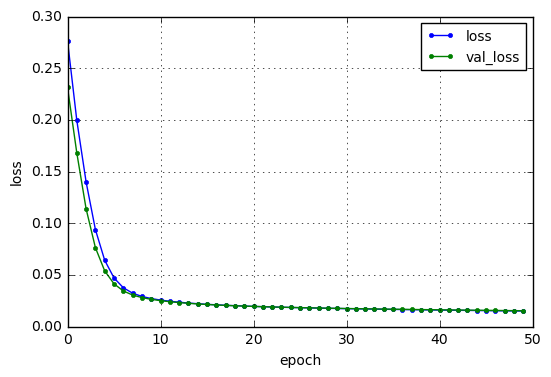

hiden node = 64
_AEdim=064_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2727 - val_loss: 0.2487
Epoch 2/50
0s - loss: 0.2297 - val_loss: 0.2096
Epoch 3/50
0s - loss: 0.1885 - val_loss: 0.1673
Epoch 4/50
0s - loss: 0.1478 - val_loss: 0.1293
Epoch 5/50
0s - loss: 0.1137 - val_loss: 0.0994
Epoch 6/50
0s - loss: 0.0881 - val_loss: 0.0778
Epoch 7/50
0s - loss: 0.0699 - val_loss: 0.0628
Epoch 8/50
0s - loss: 0.0574 - val_loss: 0.0526
Epoch 9/50
0s - loss: 0.0488 - val_loss: 0.0455
Epoch 10/50
0s - loss: 0.0428 - val_loss: 0.0405
Epoch 11/50
0s - loss: 0.0386 - val_loss: 0.0368
Epoch 12/50
0s - loss: 0.0354 - val_loss: 0.0341
Epoch 13/50
0s - loss: 0.0329 - val_loss: 0.0319
Epoch 14/50
0s - loss: 0.0309 - val_loss: 0.0301
Epoch 15/50
0s - loss: 0.0293 - val_loss: 0.0287
Epoch 16/50
0s - loss: 0.0280 - val_loss: 0.0274
Epoch 17/50
0s - loss: 0.0268 - val_loss: 0.0264
Epoch 18/50
0s - loss: 0.0259 - val_loss: 0.0255
Epoch 19/50
0s - loss: 0.0251 

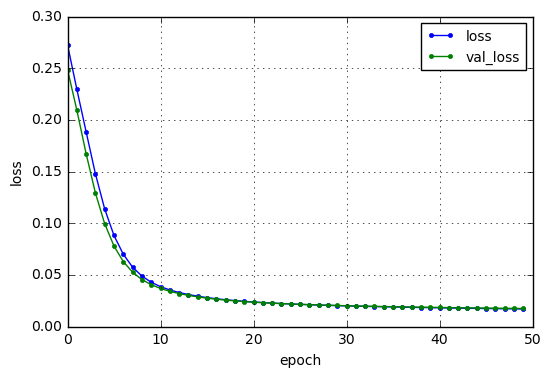

hiden node = 32
_AEdim=032_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2815 - val_loss: 0.2674
Epoch 2/50
0s - loss: 0.2555 - val_loss: 0.2424
Epoch 3/50
0s - loss: 0.2276 - val_loss: 0.2120
Epoch 4/50
0s - loss: 0.1964 - val_loss: 0.1809
Epoch 5/50
0s - loss: 0.1666 - val_loss: 0.1527
Epoch 6/50
0s - loss: 0.1405 - val_loss: 0.1288
Epoch 7/50
0s - loss: 0.1188 - val_loss: 0.1094
Epoch 8/50
0s - loss: 0.1014 - val_loss: 0.0939
Epoch 9/50
0s - loss: 0.0876 - val_loss: 0.0817
Epoch 10/50
0s - loss: 0.0768 - val_loss: 0.0721
Epoch 11/50
0s - loss: 0.0682 - val_loss: 0.0646
Epoch 12/50
0s - loss: 0.0614 - val_loss: 0.0585
Epoch 13/50
0s - loss: 0.0560 - val_loss: 0.0536
Epoch 14/50
0s - loss: 0.0515 - val_loss: 0.0496
Epoch 15/50
0s - loss: 0.0478 - val_loss: 0.0462
Epoch 16/50
0s - loss: 0.0447 - val_loss: 0.0433
Epoch 17/50
0s - loss: 0.0421 - val_loss: 0.0409
Epoch 18/50
0s - loss: 0.0398 - val_loss: 0.0388
Epoch 19/50
0s - loss: 0.0378 

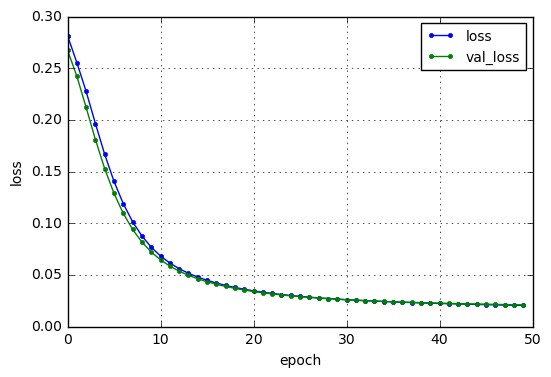

hiden node = 16
_AEdim=016_Win=1024_Sld=0128_sgd
Train on 8413 samples, validate on 8413 samples
Epoch 1/50
0s - loss: 0.2899 - val_loss: 0.2822
Epoch 2/50
0s - loss: 0.2767 - val_loss: 0.2709
Epoch 3/50
0s - loss: 0.2638 - val_loss: 0.2561
Epoch 4/50
0s - loss: 0.2473 - val_loss: 0.2381
Epoch 5/50
0s - loss: 0.2284 - val_loss: 0.2185
Epoch 6/50
0s - loss: 0.2087 - val_loss: 0.1989
Epoch 7/50
0s - loss: 0.1896 - val_loss: 0.1804
Epoch 8/50
0s - loss: 0.1719 - val_loss: 0.1636
Epoch 9/50
0s - loss: 0.1561 - val_loss: 0.1487
Epoch 10/50
0s - loss: 0.1420 - val_loss: 0.1355
Epoch 11/50
0s - loss: 0.1297 - val_loss: 0.1240
Epoch 12/50
0s - loss: 0.1189 - val_loss: 0.1139
Epoch 13/50
0s - loss: 0.1095 - val_loss: 0.1051
Epoch 14/50
0s - loss: 0.1012 - val_loss: 0.0974
Epoch 15/50
0s - loss: 0.0940 - val_loss: 0.0907
Epoch 16/50
0s - loss: 0.0877 - val_loss: 0.0847
Epoch 17/50
0s - loss: 0.0821 - val_loss: 0.0795
Epoch 18/50
0s - loss: 0.0772 - val_loss: 0.0749
Epoch 19/50
0s - loss: 0.0728 

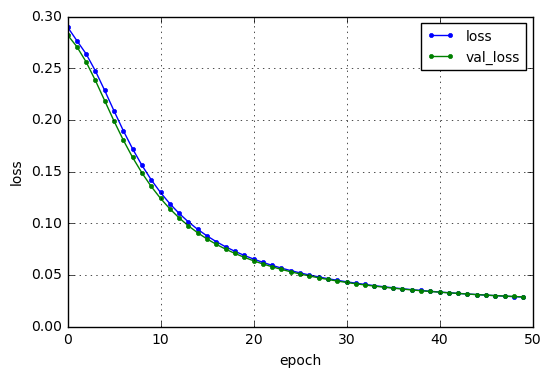

this data had finished making
hiden node = 256
_AEdim=256_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2942 - val_loss: 0.2656
Epoch 2/50
0s - loss: 0.2477 - val_loss: 0.2310
Epoch 3/50
0s - loss: 0.2160 - val_loss: 0.2009
Epoch 4/50
0s - loss: 0.1866 - val_loss: 0.1723
Epoch 5/50
0s - loss: 0.1589 - val_loss: 0.1457
Epoch 6/50
0s - loss: 0.1338 - val_loss: 0.1222
Epoch 7/50
0s - loss: 0.1122 - val_loss: 0.1026
Epoch 8/50
0s - loss: 0.0944 - val_loss: 0.0867
Epoch 9/50
0s - loss: 0.0803 - val_loss: 0.0743
Epoch 10/50
0s - loss: 0.0693 - val_loss: 0.0647
Epoch 11/50
0s - loss: 0.0610 - val_loss: 0.0575
Epoch 12/50
0s - loss: 0.0546 - val_loss: 0.0520
Epoch 13/50
0s - loss: 0.0498 - val_loss: 0.0478
Epoch 14/50
0s - loss: 0.0462 - val_loss: 0.0447
Epoch 15/50
0s - loss: 0.0435 - val_loss: 0.0423
Epoch 16/50
0s - loss: 0.0413 - val_loss: 0.0404
Epoch 17/50
0s - loss: 0.0396 - val_loss: 0.0389
Epoch 18/50
0s - loss: 0.0382 - val_loss: 0.0376

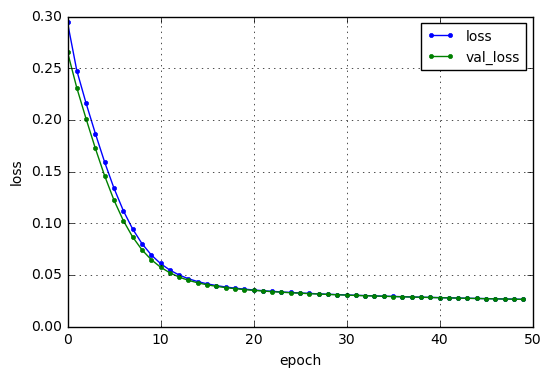

hiden node = 128
_AEdim=128_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2937 - val_loss: 0.2796
Epoch 2/50
0s - loss: 0.2705 - val_loss: 0.2620
Epoch 3/50
0s - loss: 0.2540 - val_loss: 0.2457
Epoch 4/50
0s - loss: 0.2370 - val_loss: 0.2277
Epoch 5/50
0s - loss: 0.2183 - val_loss: 0.2084
Epoch 6/50
0s - loss: 0.1987 - val_loss: 0.1887
Epoch 7/50
0s - loss: 0.1791 - val_loss: 0.1694
Epoch 8/50
0s - loss: 0.1603 - val_loss: 0.1512
Epoch 9/50
0s - loss: 0.1429 - val_loss: 0.1347
Epoch 10/50
0s - loss: 0.1272 - val_loss: 0.1199
Epoch 11/50
0s - loss: 0.1135 - val_loss: 0.1071
Epoch 12/50
0s - loss: 0.1016 - val_loss: 0.0961
Epoch 13/50
0s - loss: 0.0914 - val_loss: 0.0868
Epoch 14/50
0s - loss: 0.0828 - val_loss: 0.0790
Epoch 15/50
0s - loss: 0.0756 - val_loss: 0.0724
Epoch 16/50
0s - loss: 0.0696 - val_loss: 0.0669
Epoch 17/50
0s - loss: 0.0646 - val_loss: 0.0624
Epoch 18/50
0s - loss: 0.0604 - val_loss: 0.0585
Epoch 19/50
0s - loss: 0.0569

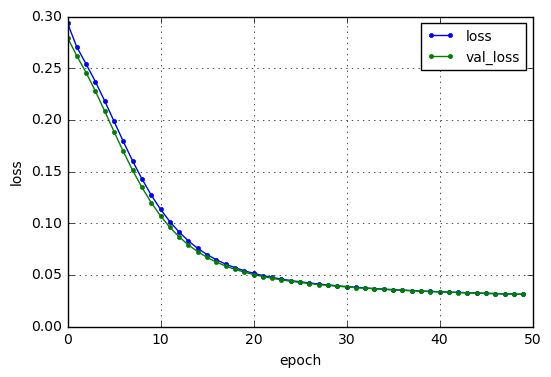

hiden node = 64
_AEdim=064_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2866 - val_loss: 0.2783
Epoch 2/50
0s - loss: 0.2727 - val_loss: 0.2672
Epoch 3/50
0s - loss: 0.2615 - val_loss: 0.2555
Epoch 4/50
0s - loss: 0.2494 - val_loss: 0.2430
Epoch 5/50
0s - loss: 0.2365 - val_loss: 0.2298
Epoch 6/50
0s - loss: 0.2230 - val_loss: 0.2161
Epoch 7/50
0s - loss: 0.2093 - val_loss: 0.2024
Epoch 8/50
0s - loss: 0.1958 - val_loss: 0.1892
Epoch 9/50
0s - loss: 0.1828 - val_loss: 0.1765
Epoch 10/50
0s - loss: 0.1705 - val_loss: 0.1646
Epoch 11/50
0s - loss: 0.1590 - val_loss: 0.1535
Epoch 12/50
0s - loss: 0.1483 - val_loss: 0.1432
Epoch 13/50
0s - loss: 0.1384 - val_loss: 0.1337
Epoch 14/50
0s - loss: 0.1294 - val_loss: 0.1251
Epoch 15/50
0s - loss: 0.1212 - val_loss: 0.1172
Epoch 16/50
0s - loss: 0.1137 - val_loss: 0.1101
Epoch 17/50
0s - loss: 0.1068 - val_loss: 0.1036
Epoch 18/50
0s - loss: 0.1007 - val_loss: 0.0978
Epoch 19/50
0s - loss: 0.0951 

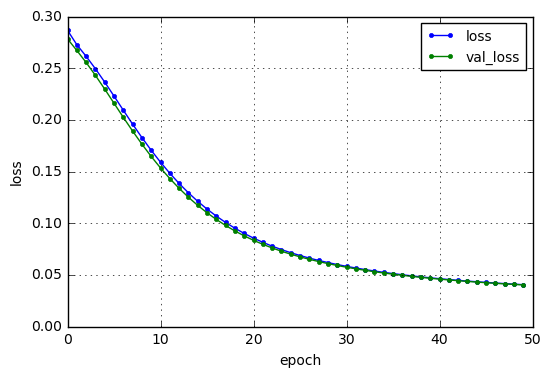

hiden node = 32
_AEdim=032_Win=2048_Sld=0256_sgd
Train on 4203 samples, validate on 4203 samples
Epoch 1/50
0s - loss: 0.2913 - val_loss: 0.2868
Epoch 2/50
0s - loss: 0.2844 - val_loss: 0.2821
Epoch 3/50
0s - loss: 0.2799 - val_loss: 0.2775
Epoch 4/50
0s - loss: 0.2749 - val_loss: 0.2721
Epoch 5/50
0s - loss: 0.2691 - val_loss: 0.2658
Epoch 6/50
0s - loss: 0.2623 - val_loss: 0.2587
Epoch 7/50
0s - loss: 0.2548 - val_loss: 0.2507
Epoch 8/50
0s - loss: 0.2465 - val_loss: 0.2422
Epoch 9/50
0s - loss: 0.2378 - val_loss: 0.2333
Epoch 10/50
0s - loss: 0.2288 - val_loss: 0.2242
Epoch 11/50
0s - loss: 0.2197 - val_loss: 0.2151
Epoch 12/50
0s - loss: 0.2107 - val_loss: 0.2062
Epoch 13/50
0s - loss: 0.2019 - val_loss: 0.1975
Epoch 14/50
0s - loss: 0.1933 - val_loss: 0.1891
Epoch 15/50
0s - loss: 0.1851 - val_loss: 0.1811
Epoch 16/50
0s - loss: 0.1772 - val_loss: 0.1733
Epoch 17/50
0s - loss: 0.1697 - val_loss: 0.1660
Epoch 18/50
0s - loss: 0.1625 - val_loss: 0.1590
Epoch 19/50
0s - loss: 0.1557 

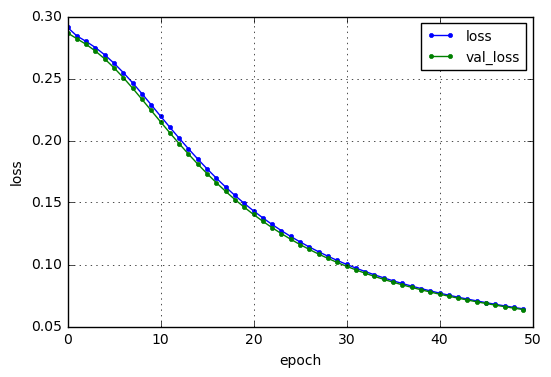

this data had finished making
hiden node = 512
_AEdim=512_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3243 - val_loss: 0.3043
Epoch 2/50
0s - loss: 0.2906 - val_loss: 0.2781
Epoch 3/50
0s - loss: 0.2688 - val_loss: 0.2597
Epoch 4/50
0s - loss: 0.2521 - val_loss: 0.2444
Epoch 5/50
0s - loss: 0.2375 - val_loss: 0.2302
Epoch 6/50
0s - loss: 0.2235 - val_loss: 0.2164
Epoch 7/50
0s - loss: 0.2097 - val_loss: 0.2027
Epoch 8/50
0s - loss: 0.1961 - val_loss: 0.1892
Epoch 9/50
0s - loss: 0.1828 - val_loss: 0.1760
Epoch 10/50
0s - loss: 0.1699 - val_loss: 0.1634
Epoch 11/50
0s - loss: 0.1575 - val_loss: 0.1513
Epoch 12/50
0s - loss: 0.1458 - val_loss: 0.1401
Epoch 13/50
0s - loss: 0.1350 - val_loss: 0.1297
Epoch 14/50
0s - loss: 0.1250 - val_loss: 0.1201
Epoch 15/50
0s - loss: 0.1159 - val_loss: 0.1115
Epoch 16/50
0s - loss: 0.1077 - val_loss: 0.1037
Epoch 17/50
0s - loss: 0.1003 - val_loss: 0.0968
Epoch 18/50
0s - loss: 0.0938 - val_loss: 0.0907

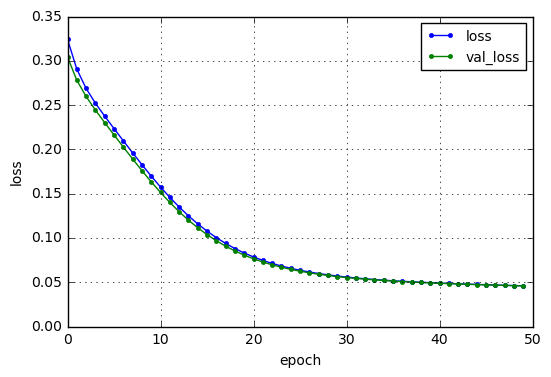

hiden node = 256
_AEdim=256_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.3058 - val_loss: 0.2954
Epoch 2/50
0s - loss: 0.2881 - val_loss: 0.2813
Epoch 3/50
0s - loss: 0.2763 - val_loss: 0.2713
Epoch 4/50
0s - loss: 0.2671 - val_loss: 0.2628
Epoch 5/50
0s - loss: 0.2589 - val_loss: 0.2547
Epoch 6/50
0s - loss: 0.2507 - val_loss: 0.2465
Epoch 7/50
0s - loss: 0.2424 - val_loss: 0.2380
Epoch 8/50
0s - loss: 0.2337 - val_loss: 0.2291
Epoch 9/50
0s - loss: 0.2248 - val_loss: 0.2200
Epoch 10/50
0s - loss: 0.2156 - val_loss: 0.2108
Epoch 11/50
0s - loss: 0.2062 - val_loss: 0.2014
Epoch 12/50
0s - loss: 0.1968 - val_loss: 0.1920
Epoch 13/50
0s - loss: 0.1875 - val_loss: 0.1828
Epoch 14/50
0s - loss: 0.1784 - val_loss: 0.1737
Epoch 15/50
0s - loss: 0.1695 - val_loss: 0.1650
Epoch 16/50
0s - loss: 0.1609 - val_loss: 0.1566
Epoch 17/50
0s - loss: 0.1527 - val_loss: 0.1486
Epoch 18/50
0s - loss: 0.1449 - val_loss: 0.1410
Epoch 19/50
0s - loss: 0.1375

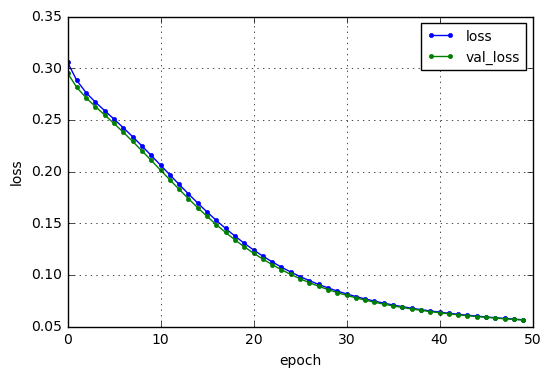

hiden node = 128
_AEdim=128_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.2970 - val_loss: 0.2913
Epoch 2/50
0s - loss: 0.2872 - val_loss: 0.2833
Epoch 3/50
0s - loss: 0.2805 - val_loss: 0.2776
Epoch 4/50
0s - loss: 0.2752 - val_loss: 0.2727
Epoch 5/50
0s - loss: 0.2703 - val_loss: 0.2677
Epoch 6/50
0s - loss: 0.2652 - val_loss: 0.2624
Epoch 7/50
0s - loss: 0.2597 - val_loss: 0.2568
Epoch 8/50
0s - loss: 0.2540 - val_loss: 0.2509
Epoch 9/50
0s - loss: 0.2478 - val_loss: 0.2446
Epoch 10/50
0s - loss: 0.2414 - val_loss: 0.2380
Epoch 11/50
0s - loss: 0.2347 - val_loss: 0.2312
Epoch 12/50
0s - loss: 0.2278 - val_loss: 0.2243
Epoch 13/50
0s - loss: 0.2209 - val_loss: 0.2173
Epoch 14/50
0s - loss: 0.2138 - val_loss: 0.2102
Epoch 15/50
0s - loss: 0.2068 - val_loss: 0.2032
Epoch 16/50
0s - loss: 0.1999 - val_loss: 0.1963
Epoch 17/50
0s - loss: 0.1930 - val_loss: 0.1896
Epoch 18/50
0s - loss: 0.1864 - val_loss: 0.1830
Epoch 19/50
0s - loss: 0.1799

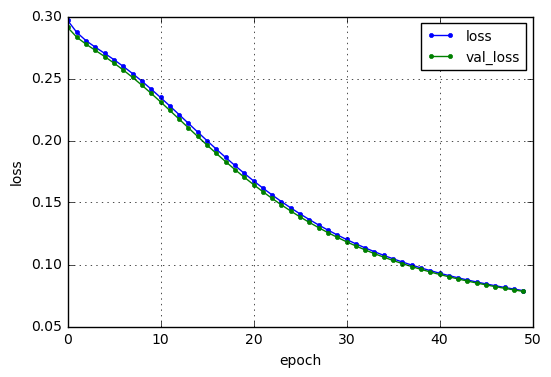

hiden node = 64
_AEdim=064_Win=4096_Sld=0512_sgd
Train on 2098 samples, validate on 2098 samples
Epoch 1/50
0s - loss: 0.2940 - val_loss: 0.2913
Epoch 2/50
0s - loss: 0.2893 - val_loss: 0.2874
Epoch 3/50
0s - loss: 0.2859 - val_loss: 0.2844
Epoch 4/50
0s - loss: 0.2832 - val_loss: 0.2819
Epoch 5/50
0s - loss: 0.2807 - val_loss: 0.2795
Epoch 6/50
0s - loss: 0.2784 - val_loss: 0.2771
Epoch 7/50
0s - loss: 0.2759 - val_loss: 0.2746
Epoch 8/50
0s - loss: 0.2732 - val_loss: 0.2718
Epoch 9/50
0s - loss: 0.2704 - val_loss: 0.2688
Epoch 10/50
0s - loss: 0.2673 - val_loss: 0.2656
Epoch 11/50
0s - loss: 0.2639 - val_loss: 0.2622
Epoch 12/50
0s - loss: 0.2604 - val_loss: 0.2586
Epoch 13/50
0s - loss: 0.2568 - val_loss: 0.2548
Epoch 14/50
0s - loss: 0.2530 - val_loss: 0.2509
Epoch 15/50
0s - loss: 0.2490 - val_loss: 0.2469
Epoch 16/50
0s - loss: 0.2449 - val_loss: 0.2428
Epoch 17/50
0s - loss: 0.2408 - val_loss: 0.2386
Epoch 18/50
0s - loss: 0.2366 - val_loss: 0.2344
Epoch 19/50
0s - loss: 0.2324 

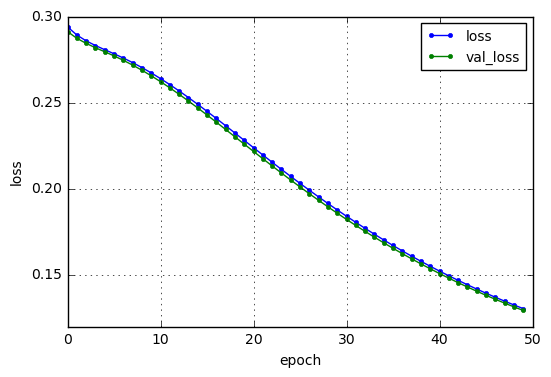

In [110]:
# loop windowWidth
WindowWidth = np.array( [256,512,1024,2048,4096] )
SlidingWidth = WindowWidth/8
BatchSize = 32
Optim='sgd'
#AEDimention = WindowWidth, WindowWidth/2, WindowWidth/4, WindowWidth/8

for WindowNum,SlidingNum in zip(WindowWidth,SlidingWidth):
    windoW = GetWindowFrame('AccX',Sensor1['AccX'],WindowNum,SlidingNum,WindowDataPath)
        
    AEDimentionS=np.array([WindowNum/8,WindowNum/16,WindowNum/32,WindowNum/64])

    #np.savez(WindowDataPath+CommonName+'_Test',data=windoW)
    #np.savez(WindowDataPath+CommonName+'_Train',data=windoW)
    
    for AEDimention in AEDimentionS:
        print "hiden node = "+str(AEDimention)
            
        CommonName='_AEdim='+str(AEDimention).zfill(3)+'_Win='+str(WindowNum).zfill(4)+\
        '_Sld='+str(SlidingNum).zfill(4)+'_'+Optim
        print CommonName

        AutoEncoder(windoW,windoW,AEDimention,Optim,CommonName,BatchSize)